# Recommender system Challenge 2022

In [1]:
!pip install scikit-optimize
!pip install lightfm 
!pip install implicit
!pip install tables
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as pyplot
import scipy.sparse as sps
import seaborn as sns
import os, multiprocessing
from sklearn.model_selection import train_test_split

You should consider upgrading via the 'c:\users\ste_9\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ste_9\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ste_9\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\ste_9\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
files = []
# 0 - sample_submission.csv
# 1 - data_ICM_type.csv
# 2 - data_target_users_test.csv
# 3 - interactions_and_impressions.csv
# 4 - data_ICM_length.csv
for dirname, _, filenames in os.walk('challenge-2022\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename))
         
ICM_series_length = pd.read_csv(files[1],
                                dtype={"item_id": np.int32,
                                       "feature_id": np.int32,
                                       "data": np.int32})

ICM_series_type = pd.read_csv(files[2],
                                dtype={"item_id": np.int32,
                                       "feature_id": np.int32,
                                       "data": np.int32})

users_to_recommend = pd.read_csv(files[3],
                                dtype={"user_id": np.int32})

URM_all = pd.read_csv(files[4], sep=',',
                      names=["user_id","item_id","impressions", "data"],
                      header=0,
                      dtype={"user_id":np.int32, "item_id":np.int32,
                             "impressions":str, "data":np.int32})

challenge-2022\data\alg_sample_submission.csv
challenge-2022\data\data_ICM_length.csv
challenge-2022\data\data_ICM_type.csv
challenge-2022\data\data_target_users_test.csv
challenge-2022\data\interactions_and_impressions.csv


# Preprocess data

This function re-arrange the user id and item id in URM_interactions and at the same time update them also in the two ICMs

In [3]:
def preprocess_data(interactions: pd.DataFrame):
    unique_users = interactions.user_id.unique()
    unique_items = interactions.item_id.unique()
    
    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()
    
    print(f'{num_users} users, min: {min_user_id}, max: {max_user_id}')
    print(f'{num_items} items, min: {min_item_id}, max: {max_item_id}')
    
    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})
    
    interactions = pd.merge(left=interactions, 
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")
    
    interactions = pd.merge(left=interactions, 
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")

    return interactions

In [4]:
URM_preproc = preprocess_data(URM_all)

41629 users, min: 0, max: 41628
24507 items, min: 0, max: 24506


In [5]:
#check unicity of items in URM and ICM_series_type

mapped_id, original_id = pd.factorize(URM_preproc["item_id"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_preproc["item_id"], ICM_series_type["item_id"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM_series_type are {}".format(len(original_id)))

item_original_ID_to_index_type = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM_series_type are 27968


In [6]:
#check unicity of items in URM and ICM_series_length


mapped_id, original_id = pd.factorize(URM_preproc["item_id"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_preproc["item_id"], ICM_series_length["item_id"]], ignore_index=True)

mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM_series_length are {}".format(len(original_id)))
item_original_ID_to_index_length = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM_series_length are 27968


In [7]:
mapped_id, original_id = pd.factorize(ICM_series_type["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique FeatureID in the ICM_type are {}".format(len(feature_original_ID_to_index)))

Unique FeatureID in the ICM_type are 5


In [8]:
ICM_series_type["mapped_item_id"] = ICM_series_type["item_id"].map(item_original_ID_to_index_type)
ICM_series_type["mapped_feature_id"] = ICM_series_type["feature_id"].map(feature_original_ID_to_index)

ICM_series_type

,item_id,feature_id,data,mapped_item_id,mapped_feature_id
0,0,1,1,3668,0
1,1,3,1,1945,1
2,2,4,1,18373,2
3,3,1,1,7153,0
4,4,3,1,3423,1
...,...,...,...,...,...
23086,27963,1,1,27963,0
23087,27964,2,1,27964,3
23088,27965,1,1,27965,0
23089,27966,1,1,27966,0


In [9]:
ICM_series_length["mapped_item_id"] = ICM_series_length["item_id"].map(item_original_ID_to_index_length)
ICM_series_length

,item_id,feature_id,data,mapped_item_id
0,0,0,1,3668
1,1,0,1,1945
2,2,0,21,18373
3,3,0,1,7153
4,4,0,1,3423
...,...,...,...,...
23086,27963,0,1,27963
23087,27964,0,1,27964
23088,27965,0,1,27965
23089,27966,0,1,27966


### Remove from ICM_series_type items having no interactions in URM

We see that all items with ID >= 24507 have not interaction in URM, so we remove them from ICM_series_length

In [10]:
ICM_series_type = ICM_series_type[ICM_series_type["item_id"].isin(URM_preproc["item_id"])]
ICM_series_type

,item_id,feature_id,data,mapped_item_id,mapped_feature_id
0,0,1,1,3668,0
1,1,3,1,1945,1
2,2,4,1,18373,2
3,3,1,1,7153,0
4,4,3,1,3423,1
...,...,...,...,...,...
19625,24502,1,1,24300,0
19626,24503,4,1,19410,2
19627,24504,1,1,13665,0
19628,24505,4,1,17793,2


In [11]:
#check unicity of items in URM and ICM_series_type

mapped_id, original_id = pd.factorize(URM_preproc["item_id"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_preproc["item_id"], ICM_series_type["item_id"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM_series_type are {}".format(len(original_id)))

item_original_ID_to_index_type = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM_series_type are 24507


### Remove from ICM_series_length items having no interactions in URM

We see that all items with ID >= 24507 have not interaction in URM, so we remove them from ICM_series_length

In [12]:
ICM_series_length = ICM_series_length[ICM_series_length["item_id"].isin(URM_preproc["item_id"])]  
ICM_series_length

,item_id,feature_id,data,mapped_item_id
0,0,0,1,3668
1,1,0,1,1945
2,2,0,21,18373
3,3,0,1,7153
4,4,0,1,3423
...,...,...,...,...
19625,24502,0,1,24300
19626,24503,0,6,19410
19627,24504,0,1,13665
19628,24505,0,1001,17793


In [13]:
#check unicity of items in URM and ICM_series_length

mapped_id, original_id = pd.factorize(URM_preproc["item_id"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_preproc["item_id"], ICM_series_length["item_id"]], ignore_index=True)

mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM_series_length are {}".format(len(original_id)))
item_original_ID_to_index_length = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM_series_length are 24507


## Normalize data

In [30]:
# URM_log['data'] = URM_log.data.astype(float)
# URM_log.dtypes

user_id             int32
item_id             int32
impressions        object
data              float64
mapped_user_id      int64
mapped_item_id      int64
dtype: object

# Group by users and items to obtain a single row for every pair user-item

In [31]:
URM_prova = URM_preproc
URM_prova

,user_id,item_id,impressions,data,mapped_user_id,mapped_item_id
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,0,0
1,2988,11,NaN,1,2988,0
2,3144,11,NaN,0,3144,0
3,3396,11,NaN,0,3396,0
4,3567,11,"1,2,3,5,7,108,8,9,10,11,12,13,14,15,16,17,18,19",1,3567,0
...,...,...,...,...,...,...
5826501,32742,2538,NaN,1,32742,24506
5826502,34740,2538,NaN,1,34740,24506
5826503,37175,2538,NaN,0,37175,24506
5826504,37299,2538,NaN,0,37299,24506


In [35]:
URM_views = URM_prova.assign(views=URM_prova.data)
URM_details = URM_prova.assign(details=URM_prova.data)
URM_views

,user_id,item_id,impressions,data,mapped_user_id,mapped_item_id,views
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,0,0,1
1,2988,11,NaN,1,2988,0,1
2,3144,11,NaN,0,3144,0,0
3,3396,11,NaN,0,3396,0,0
4,3567,11,"1,2,3,5,7,108,8,9,10,11,12,13,14,15,16,17,18,19",1,3567,0,1
...,...,...,...,...,...,...,...
5826501,32742,2538,NaN,1,32742,24506,1
5826502,34740,2538,NaN,1,34740,24506,1
5826503,37175,2538,NaN,0,37175,24506,0
5826504,37299,2538,NaN,0,37299,24506,0


In [34]:
URM_details.shape == URM_views.shape

True

In [36]:
URM_views = URM_views.groupby(by=["user_id", "mapped_user_id", "item_id", "mapped_item_id"], as_index=False)["views"].apply(lambda x: (x==0).sum())

In [37]:
URM_views

,user_id,mapped_user_id,item_id,mapped_item_id,views
0,0,0,11,0,0
1,0,0,21,1,3
2,0,0,22,2,0
3,0,0,24,3,0
4,0,0,44,4,0
...,...,...,...,...,...
1554635,41628,41628,20448,3700,1
1554636,41628,41628,20896,12694,0
1554637,41628,41628,21506,15132,0
1554638,41628,41628,22882,18128,1


In [40]:
URM_views.to_csv("./df_views.csv", index=False)

In [38]:
URM_details = URM_details.groupby(by=["user_id", "mapped_user_id", "item_id", "mapped_item_id"], as_index=False)["details"].apply(lambda x: (x==1).sum())
URM_details

,user_id,mapped_user_id,item_id,mapped_item_id,details
0,0,0,11,0,1
1,0,0,21,1,9
2,0,0,22,2,15
3,0,0,24,3,1
4,0,0,44,4,1
...,...,...,...,...,...
1554635,41628,41628,20448,3700,0
1554636,41628,41628,20896,12694,1
1554637,41628,41628,21506,15132,1
1554638,41628,41628,22882,18128,0


In [41]:
URM_details.to_csv("./df_details.csv", index=False)

# Load dataframes of views and interactions 

In [3]:
URM_views = pd.read_csv("./df_views.csv") 
URM_details = pd.read_csv("./df_details.csv")

In [4]:
URM_views.shape == URM_details.shape

True

In [5]:
URM_views_details = URM_views

In [6]:
URM_views_details["details"] = URM_details["details"]

In [7]:
URM_views_details

,user_id,mapped_user_id,item_id,mapped_item_id,views,details
0,0,0,11,0,0,1
1,0,0,21,1,3,9
2,0,0,22,2,0,15
3,0,0,24,3,0,1
4,0,0,44,4,0,1
...,...,...,...,...,...,...
1554635,41628,41628,20448,3700,1,0
1554636,41628,41628,20896,12694,0,1
1554637,41628,41628,21506,15132,0,1
1554638,41628,41628,22882,18128,1,0


In [43]:
import math
URM_temp = URM_preproc.drop(columns="impressions")
URM_temp = URM_temp.groupby(by=["user_id", "mapped_user_id", "item_id", "mapped_item_id"], as_index=False).count()
URM_temp['data'] = URM_temp.data.astype(float)
URM_temp['data'] = np.log(np.log(URM_temp['data'] + 1) + 1) 

In [44]:
URM_temp

,user_id,mapped_user_id,item_id,mapped_item_id,data
0,0,0,11,0,0.526589
1,0,0,21,1,1.271150
2,0,0,22,2,1.327761
3,0,0,24,3,0.526589
4,0,0,44,4,0.526589
...,...,...,...,...,...
1554635,41628,41628,20448,3700,0.526589
1554636,41628,41628,20896,12694,0.526589
1554637,41628,41628,21506,15132,0.526589
1554638,41628,41628,22882,18128,0.526589


# Convert in CSR format

In [6]:
URM_tmp_coo = sps.coo_matrix((URM_temp["data"].values, 
                          (URM_temp["mapped_user_id"].values, URM_temp["mapped_item_id"].values)))
URM_all = URM_tmp_coo.tocsr()

In [ ]:
ICM_length_coo = sps.coo_matrix((ICM_series_length["data"].values, 
                          (ICM_series_length["item_id"].values, ICM_series_length["feature_id"].values)))
ICM_length = ICM_length_coo.tocsr()


#types are 1, 3, 4, 2, 7 ==> 5 types of items
ICM_type_coo = sps.coo_matrix((ICM_series_type["data"].values, 
                          (ICM_series_type["item_id"].values, ICM_series_type["mapped_feature_id"].values)))
ICM_type = ICM_type_coo.tocsr()

In [ ]:
URM_all, ICM_type, ICM_length

(<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
 	with 1554640 stored elements in Compressed Sparse Row format>,
 <24507x5 sparse matrix of type '<class 'numpy.int32'>'
 	with 19630 stored elements in Compressed Sparse Row format>,
 <24507x1 sparse matrix of type '<class 'numpy.int32'>'
 	with 19630 stored elements in Compressed Sparse Row format>)

# Sum details and views for every user tuning weights and logarithm base 

In [8]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_user_wise, split_train_in_two_percentage_global_sample

In [63]:
import time

bestMAP = 0.0
best_hyper = {}
for i in range(0, 500):
    print(f" starting iterarion {i}..")
    start = time.time()
    base = np.random.uniform(12, 100)
    w_views = np.random.uniform(70, 100)
    #w_details = np.random.uniform(0, 100)
    
    #tuning of the best base and weights
    URM_views_details["data"] = np.log(w_views*URM_views_details["views"] + (100 - w_views)*URM_views_details["details"] + 1) / np.log(base)
 
    URM_tmp_coo = sps.coo_matrix((URM_views_details["data"].values, 
                          (URM_views_details["mapped_user_id"].values, URM_views_details["mapped_item_id"].values)))
    URM_all = URM_tmp_coo.tocsr()
    URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.9)
    URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.9)

    evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
    
    #fit on the best RP3Beta
    recommenderRP3Beta = RP3betaRecommender(URM_train)
    recommenderRP3Beta.fit(topK=230, alpha=0.5538028817676098, beta=0.3725401274854678, normalize_similarity=True) #hyperparameters gotten from tuning

    result_df, _ = evaluator_validation.evaluateRecommender(recommenderRP3Beta)
    if result_df["MAP_MIN_DEN"][10] > bestMAP:
        bestMAP = result_df["MAP_MIN_DEN"][10]
        print(f"MAP_MIN_DEN={bestMAP}, new best parameters found for URM: b={base}, w_v={w_views}, w_d={w_details}")
        best_hyper = {"base": base,"weight_views": w_views, "weight_details": w_details}
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Iterarion {i} finished in {int(hours)}:{int(minutes)}:{int(seconds)}")
    

 starting iterarion 0..
EvaluatorHoldout: Ignoring 3585 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2094.80 column/sec. Elapsed time 11.70 sec
EvaluatorHoldout: Processed 38044 (100.0%) in 25.67 sec. Users per second: 1482
MAP_MIN_DEN=0.03568628869569625, new best parameters found for URM: b=39.620545466297955, w_v=72.68419957491912, w_d=35.46566189175019
Iterarion 0 finished in 0:0:46
 starting iterarion 1..
EvaluatorHoldout: Ignoring 3651 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2261.30 column/sec. Elapsed time 10.84 sec
EvaluatorHoldout: Processed 37978 (100.0%) in 23.31 sec. Users per second: 1630
MAP_MIN_DEN=0.03578657450662194, new best parameters found for URM: b=58.16771823408399, w_v=74.12747983658318, w_d=35.46566189175019
Iterarion 1 finished in 0:0:42
 starting iterarion 2..
EvaluatorHoldout: Ignoring 3475 ( 8.3%) Users that have less than 1 tes

EvaluatorHoldout: Ignoring 3653 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2271.34 column/sec. Elapsed time 10.79 sec
EvaluatorHoldout: Processed 37976 (100.0%) in 23.54 sec. Users per second: 1613
Iterarion 17 finished in 0:0:42
 starting iterarion 18..
EvaluatorHoldout: Ignoring 3616 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2261.49 column/sec. Elapsed time 10.84 sec
EvaluatorHoldout: Processed 38013 (100.0%) in 23.33 sec. Users per second: 1629
Iterarion 18 finished in 0:0:42
 starting iterarion 19..
EvaluatorHoldout: Ignoring 3604 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2280.53 column/sec. Elapsed time 10.75 sec
EvaluatorHoldout: Processed 38025 (100.0%) in 23.52 sec. Users per second: 1617
Iterarion 19 finished in 0:0:42
 starting iterarion 20..
EvaluatorHoldout: Ignoring 3616 ( 8.7%) 

RP3betaRecommender: Similarity column 24507 (100.0%), 2091.63 column/sec. Elapsed time 11.72 sec
EvaluatorHoldout: Processed 37979 (100.0%) in 25.13 sec. Users per second: 1511
Iterarion 35 finished in 0:0:45
 starting iterarion 36..
EvaluatorHoldout: Ignoring 3599 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2091.16 column/sec. Elapsed time 11.72 sec
EvaluatorHoldout: Processed 38030 (100.0%) in 25.16 sec. Users per second: 1512
Iterarion 36 finished in 0:0:45
 starting iterarion 37..
EvaluatorHoldout: Ignoring 3606 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2084.84 column/sec. Elapsed time 11.75 sec
EvaluatorHoldout: Processed 38023 (100.0%) in 25.22 sec. Users per second: 1508
Iterarion 37 finished in 0:0:46
 starting iterarion 38..
EvaluatorHoldout: Ignoring 3490 ( 8.4%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24

EvaluatorHoldout: Processed 38094 (100.0%) in 25.21 sec. Users per second: 1511
Iterarion 53 finished in 0:0:46
 starting iterarion 54..
EvaluatorHoldout: Ignoring 3460 ( 8.3%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2118.02 column/sec. Elapsed time 11.57 sec
EvaluatorHoldout: Processed 38169 (100.0%) in 25.17 sec. Users per second: 1516
Iterarion 54 finished in 0:0:45
 starting iterarion 55..
EvaluatorHoldout: Ignoring 3614 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2099.94 column/sec. Elapsed time 11.67 sec
EvaluatorHoldout: Processed 38015 (100.0%) in 24.94 sec. Users per second: 1524
Iterarion 55 finished in 0:0:45
 starting iterarion 56..
EvaluatorHoldout: Ignoring 3569 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2108.87 column/sec. Elapsed time 11.62 sec
EvaluatorHoldout: Processed 38060 (100.0

RP3betaRecommender: Similarity column 24507 (100.0%), 2091.91 column/sec. Elapsed time 11.72 sec
EvaluatorHoldout: Processed 37995 (100.0%) in 25.04 sec. Users per second: 1517
Iterarion 72 finished in 0:0:46
 starting iterarion 73..
EvaluatorHoldout: Ignoring 3614 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2108.02 column/sec. Elapsed time 11.63 sec
EvaluatorHoldout: Processed 38015 (100.0%) in 24.89 sec. Users per second: 1527
Iterarion 73 finished in 0:0:45
 starting iterarion 74..
EvaluatorHoldout: Ignoring 3625 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2103.52 column/sec. Elapsed time 11.65 sec
EvaluatorHoldout: Processed 38004 (100.0%) in 24.95 sec. Users per second: 1523
Iterarion 74 finished in 0:0:45
 starting iterarion 75..
EvaluatorHoldout: Ignoring 3655 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24

Iterarion 90 finished in 0:0:45
 starting iterarion 91..
EvaluatorHoldout: Ignoring 3669 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2103.04 column/sec. Elapsed time 11.65 sec
EvaluatorHoldout: Processed 37960 (100.0%) in 25.01 sec. Users per second: 1518
Iterarion 91 finished in 0:0:45
 starting iterarion 92..
EvaluatorHoldout: Ignoring 3641 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2077.58 column/sec. Elapsed time 11.80 sec
EvaluatorHoldout: Processed 37988 (100.0%) in 24.95 sec. Users per second: 1523
Iterarion 92 finished in 0:0:45
 starting iterarion 93..
EvaluatorHoldout: Ignoring 3613 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2095.87 column/sec. Elapsed time 11.69 sec
EvaluatorHoldout: Processed 38016 (100.0%) in 25.01 sec. Users per second: 1520
Iterarion 93 finished in 0:0:45
 startin

RP3betaRecommender: Similarity column 24507 (100.0%), 2109.54 column/sec. Elapsed time 11.62 sec
EvaluatorHoldout: Processed 38091 (100.0%) in 25.10 sec. Users per second: 1517
Iterarion 109 finished in 0:0:45
 starting iterarion 110..
EvaluatorHoldout: Ignoring 3549 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2108.58 column/sec. Elapsed time 11.62 sec
EvaluatorHoldout: Processed 38080 (100.0%) in 25.00 sec. Users per second: 1523
Iterarion 110 finished in 0:0:45
 starting iterarion 111..
EvaluatorHoldout: Ignoring 3580 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2097.80 column/sec. Elapsed time 11.68 sec
EvaluatorHoldout: Processed 38049 (100.0%) in 25.28 sec. Users per second: 1505
Iterarion 111 finished in 0:0:45
 starting iterarion 112..
EvaluatorHoldout: Ignoring 3579 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity col

EvaluatorHoldout: Ignoring 3547 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2097.69 column/sec. Elapsed time 11.68 sec
EvaluatorHoldout: Processed 38082 (100.0%) in 26.51 sec. Users per second: 1437
Iterarion 128 finished in 0:0:47
 starting iterarion 129..
EvaluatorHoldout: Ignoring 3643 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2165.32 column/sec. Elapsed time 11.32 sec
EvaluatorHoldout: Processed 37986 (100.0%) in 26.34 sec. Users per second: 1442
Iterarion 129 finished in 0:0:46
 starting iterarion 130..
EvaluatorHoldout: Ignoring 3643 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 1944.18 column/sec. Elapsed time 12.61 sec
EvaluatorHoldout: Processed 37986 (100.0%) in 27.15 sec. Users per second: 1399
Iterarion 130 finished in 0:0:49
 starting iterarion 131..
EvaluatorHoldout: Ignoring 3648 ( 

EvaluatorHoldout: Processed 37997 (100.0%) in 23.26 sec. Users per second: 1634
Iterarion 146 finished in 0:0:42
 starting iterarion 147..
EvaluatorHoldout: Ignoring 3565 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2245.53 column/sec. Elapsed time 10.91 sec
EvaluatorHoldout: Processed 38064 (100.0%) in 23.51 sec. Users per second: 1619
MAP_MIN_DEN=0.03645145125980799, new best parameters found for URM: b=60.61456436571373, w_v=77.96814440678867, w_d=35.46566189175019
Iterarion 147 finished in 0:0:43
 starting iterarion 148..
EvaluatorHoldout: Ignoring 3634 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2275.73 column/sec. Elapsed time 10.77 sec
EvaluatorHoldout: Processed 37995 (100.0%) in 23.30 sec. Users per second: 1631
Iterarion 148 finished in 0:0:42
 starting iterarion 149..
EvaluatorHoldout: Ignoring 3595 ( 8.6%) Users that have less than 1 test interactio

EvaluatorHoldout: Processed 38043 (100.0%) in 23.49 sec. Users per second: 1620
Iterarion 164 finished in 0:0:43
 starting iterarion 165..
EvaluatorHoldout: Ignoring 3474 ( 8.3%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2282.26 column/sec. Elapsed time 10.74 sec
EvaluatorHoldout: Processed 38155 (100.0%) in 23.37 sec. Users per second: 1632
Iterarion 165 finished in 0:0:42
 starting iterarion 166..
EvaluatorHoldout: Ignoring 3689 ( 8.9%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2254.57 column/sec. Elapsed time 10.87 sec
EvaluatorHoldout: Processed 37940 (100.0%) in 23.34 sec. Users per second: 1625
Iterarion 166 finished in 0:0:43
 starting iterarion 167..
EvaluatorHoldout: Ignoring 3641 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2203.87 column/sec. Elapsed time 11.12 sec
EvaluatorHoldout: Processed 37988 

RP3betaRecommender: Similarity column 24507 (100.0%), 2264.87 column/sec. Elapsed time 10.82 sec
EvaluatorHoldout: Processed 37948 (100.0%) in 23.28 sec. Users per second: 1630
Iterarion 183 finished in 0:0:42
 starting iterarion 184..
EvaluatorHoldout: Ignoring 3666 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2271.86 column/sec. Elapsed time 10.79 sec
EvaluatorHoldout: Processed 37963 (100.0%) in 23.52 sec. Users per second: 1614
Iterarion 184 finished in 0:0:42
 starting iterarion 185..
EvaluatorHoldout: Ignoring 3680 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2280.68 column/sec. Elapsed time 10.75 sec
EvaluatorHoldout: Processed 37949 (100.0%) in 23.66 sec. Users per second: 1604
Iterarion 185 finished in 0:0:42
 starting iterarion 186..
EvaluatorHoldout: Ignoring 3712 ( 8.9%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity col

EvaluatorHoldout: Ignoring 3533 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2270.31 column/sec. Elapsed time 10.79 sec
EvaluatorHoldout: Processed 38096 (100.0%) in 23.57 sec. Users per second: 1616
Iterarion 202 finished in 0:0:42
 starting iterarion 203..
EvaluatorHoldout: Ignoring 3579 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2255.23 column/sec. Elapsed time 10.87 sec
EvaluatorHoldout: Processed 38050 (100.0%) in 23.93 sec. Users per second: 1590
Iterarion 203 finished in 0:0:43
 starting iterarion 204..
EvaluatorHoldout: Ignoring 3627 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2265.54 column/sec. Elapsed time 10.82 sec
EvaluatorHoldout: Processed 38002 (100.0%) in 23.52 sec. Users per second: 1616
Iterarion 204 finished in 0:0:42
 starting iterarion 205..
EvaluatorHoldout: Ignoring 3652 ( 

RP3betaRecommender: Similarity column 24507 (100.0%), 2272.28 column/sec. Elapsed time 10.79 sec
EvaluatorHoldout: Processed 38043 (100.0%) in 23.60 sec. Users per second: 1612
Iterarion 220 finished in 0:0:43
 starting iterarion 221..
EvaluatorHoldout: Ignoring 3661 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2263.19 column/sec. Elapsed time 10.83 sec
EvaluatorHoldout: Processed 37968 (100.0%) in 23.41 sec. Users per second: 1622
Iterarion 221 finished in 0:0:42
 starting iterarion 222..
EvaluatorHoldout: Ignoring 3569 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2272.00 column/sec. Elapsed time 10.79 sec
EvaluatorHoldout: Processed 38060 (100.0%) in 23.64 sec. Users per second: 1610
Iterarion 222 finished in 0:0:43
 starting iterarion 223..
EvaluatorHoldout: Ignoring 3669 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity col

EvaluatorHoldout: Ignoring 3578 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2280.04 column/sec. Elapsed time 10.75 sec
EvaluatorHoldout: Processed 38051 (100.0%) in 23.51 sec. Users per second: 1618
Iterarion 239 finished in 0:0:42
 starting iterarion 240..
EvaluatorHoldout: Ignoring 3718 ( 8.9%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2287.63 column/sec. Elapsed time 10.71 sec
EvaluatorHoldout: Processed 37911 (100.0%) in 23.37 sec. Users per second: 1622
Iterarion 240 finished in 0:0:42
 starting iterarion 241..
EvaluatorHoldout: Ignoring 3680 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2275.72 column/sec. Elapsed time 10.77 sec
EvaluatorHoldout: Processed 37949 (100.0%) in 23.18 sec. Users per second: 1637
Iterarion 241 finished in 0:0:42
 starting iterarion 242..
EvaluatorHoldout: Ignoring 3579 ( 

EvaluatorHoldout: Processed 37947 (100.0%) in 23.70 sec. Users per second: 1601
Iterarion 257 finished in 0:0:43
 starting iterarion 258..
EvaluatorHoldout: Ignoring 3529 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2212.94 column/sec. Elapsed time 11.07 sec
EvaluatorHoldout: Processed 38100 (100.0%) in 23.74 sec. Users per second: 1605
Iterarion 258 finished in 0:0:43
 starting iterarion 259..
EvaluatorHoldout: Ignoring 3672 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2232.03 column/sec. Elapsed time 10.98 sec
EvaluatorHoldout: Processed 37957 (100.0%) in 23.69 sec. Users per second: 1602
Iterarion 259 finished in 0:0:43
 starting iterarion 260..
EvaluatorHoldout: Ignoring 3698 ( 8.9%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2218.44 column/sec. Elapsed time 11.05 sec
EvaluatorHoldout: Processed 37931 

RP3betaRecommender: Similarity column 24507 (100.0%), 2285.70 column/sec. Elapsed time 10.72 sec
EvaluatorHoldout: Processed 37987 (100.0%) in 23.61 sec. Users per second: 1609
Iterarion 276 finished in 0:0:42
 starting iterarion 277..
EvaluatorHoldout: Ignoring 3595 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2227.14 column/sec. Elapsed time 11.00 sec
EvaluatorHoldout: Processed 38034 (100.0%) in 23.66 sec. Users per second: 1608
Iterarion 277 finished in 0:0:43
 starting iterarion 278..
EvaluatorHoldout: Ignoring 3621 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2189.33 column/sec. Elapsed time 11.19 sec
EvaluatorHoldout: Processed 38008 (100.0%) in 23.75 sec. Users per second: 1600
Iterarion 278 finished in 0:0:43
 starting iterarion 279..
EvaluatorHoldout: Ignoring 3554 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity col

EvaluatorHoldout: Ignoring 3559 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2233.46 column/sec. Elapsed time 10.97 sec
EvaluatorHoldout: Processed 38070 (100.0%) in 23.78 sec. Users per second: 1601
Iterarion 295 finished in 0:0:43
 starting iterarion 296..
EvaluatorHoldout: Ignoring 3569 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2228.32 column/sec. Elapsed time 11.00 sec
EvaluatorHoldout: Processed 38060 (100.0%) in 23.86 sec. Users per second: 1595
Iterarion 296 finished in 0:0:43
 starting iterarion 297..
EvaluatorHoldout: Ignoring 3554 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2227.34 column/sec. Elapsed time 11.00 sec
EvaluatorHoldout: Processed 38075 (100.0%) in 23.71 sec. Users per second: 1606
Iterarion 297 finished in 0:0:43
 starting iterarion 298..
EvaluatorHoldout: Ignoring 3559 ( 

EvaluatorHoldout: Processed 37997 (100.0%) in 23.69 sec. Users per second: 1604
Iterarion 313 finished in 0:0:43
 starting iterarion 314..
EvaluatorHoldout: Ignoring 3663 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2225.39 column/sec. Elapsed time 11.01 sec
EvaluatorHoldout: Processed 37966 (100.0%) in 23.97 sec. Users per second: 1584
Iterarion 314 finished in 0:0:43
 starting iterarion 315..
EvaluatorHoldout: Ignoring 3608 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2236.48 column/sec. Elapsed time 10.96 sec
EvaluatorHoldout: Processed 38021 (100.0%) in 23.61 sec. Users per second: 1610
Iterarion 315 finished in 0:0:43
 starting iterarion 316..
EvaluatorHoldout: Ignoring 3606 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2221.78 column/sec. Elapsed time 11.03 sec
EvaluatorHoldout: Processed 38023 

RP3betaRecommender: Similarity column 24507 (100.0%), 1949.97 column/sec. Elapsed time 12.57 sec
EvaluatorHoldout: Processed 38073 (100.0%) in 23.80 sec. Users per second: 1600
Iterarion 332 finished in 0:0:45
 starting iterarion 333..
EvaluatorHoldout: Ignoring 3619 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2220.82 column/sec. Elapsed time 11.04 sec
EvaluatorHoldout: Processed 38010 (100.0%) in 23.71 sec. Users per second: 1603
Iterarion 333 finished in 0:0:43
 starting iterarion 334..
EvaluatorHoldout: Ignoring 3675 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2217.90 column/sec. Elapsed time 11.05 sec
EvaluatorHoldout: Processed 37954 (100.0%) in 23.79 sec. Users per second: 1595
Iterarion 334 finished in 0:0:43
 starting iterarion 335..
EvaluatorHoldout: Ignoring 3597 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity col

Iterarion 350 finished in 0:0:43
 starting iterarion 351..
EvaluatorHoldout: Ignoring 3682 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2222.88 column/sec. Elapsed time 11.02 sec
EvaluatorHoldout: Processed 37947 (100.0%) in 23.78 sec. Users per second: 1596
Iterarion 351 finished in 0:0:43
 starting iterarion 352..
EvaluatorHoldout: Ignoring 3566 ( 8.6%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2196.04 column/sec. Elapsed time 11.16 sec
EvaluatorHoldout: Processed 38063 (100.0%) in 23.73 sec. Users per second: 1604
Iterarion 352 finished in 0:0:43
 starting iterarion 353..
EvaluatorHoldout: Ignoring 3648 ( 8.8%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2229.83 column/sec. Elapsed time 10.99 sec
EvaluatorHoldout: Processed 37981 (100.0%) in 23.65 sec. Users per second: 1606
Iterarion 353 finished in 0:0:43
 

RP3betaRecommender: Similarity column 24507 (100.0%), 2213.68 column/sec. Elapsed time 11.07 sec
EvaluatorHoldout: Processed 37974 (100.0%) in 23.63 sec. Users per second: 1607
Iterarion 369 finished in 0:0:43
 starting iterarion 370..
EvaluatorHoldout: Ignoring 3486 ( 8.4%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2245.49 column/sec. Elapsed time 10.91 sec
EvaluatorHoldout: Processed 38143 (100.0%) in 23.95 sec. Users per second: 1593
Iterarion 370 finished in 0:0:43
 starting iterarion 371..
EvaluatorHoldout: Ignoring 3526 ( 8.5%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity column 24507 (100.0%), 2222.98 column/sec. Elapsed time 11.02 sec
EvaluatorHoldout: Processed 38103 (100.0%) in 23.62 sec. Users per second: 1613
Iterarion 371 finished in 0:0:43
 starting iterarion 372..
EvaluatorHoldout: Ignoring 3629 ( 8.7%) Users that have less than 1 test interactions
RP3betaRecommender: Similarity col

KeyboardInterrupt: 

# Train test splitting

### The obtained tuned URM (HYPERPARAMETERS MUST TAKE RP3BETA AT LEAST 0.038 OF MAP)

In [70]:
#Paolo hyperparameters
# base=12.62329790627502
# w_views=82.89881321660107 
# w_details=27.811514733648256

#hyperparameters for URM gotten from tuning 
#whit these RP3Beta got a MAP=0.037519212714360116 
# base=8.795911971412087
# w_views=87.28932056942516
# w_details=79.45671852520626
base=61.14107762221363
w_views=82.2414887555765
w_details=35.46566189175019

URM_views_details["data"] = np.log(w_views*URM_views_details["views"] + w_details*URM_views_details["details"] + 1) / np.log(base)
URM_tmp_coo = sps.coo_matrix((URM_views_details["data"].values, 
                      (URM_views_details["mapped_user_id"].values, URM_views_details["mapped_item_id"].values)))
URM_all = URM_tmp_coo.tocsr()

In [71]:
URM_views_details.describe()

,user_id,mapped_user_id,item_id,mapped_item_id,views,details,data
count,1.554640e+06,1.554640e+06,1.554640e+06,1.554640e+06,1.554640e+06,1.554640e+06,1.554640e+06
mean,1.956944e+04,1.956944e+04,8.338677e+03,7.875555e+03,2.294730e+00,1.453087e+00,1.096488e+00
std,1.145558e+04,1.145558e+04,7.721546e+03,7.235473e+03,1.441654e+01,1.053575e+01,2.359710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.743521e-01
25%,9.709000e+03,9.709000e+03,1.154000e+03,1.331000e+03,0.000000e+00,0.000000e+00,8.743521e-01
50%,1.940500e+04,1.940500e+04,5.885000e+03,5.496000e+03,1.000000e+00,0.000000e+00,1.075018e+00
75%,2.914700e+04,2.914700e+04,1.486500e+04,1.332900e+04,1.000000e+00,1.000000e+00,1.075018e+00
max,4.162800e+04,4.162800e+04,2.450600e+04,2.450600e+04,2.801000e+03,4.256000e+03,3.041507e+00


In [72]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.9)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.9)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 3505 ( 8.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2825 ( 6.8%) Users that have less than 1 test interactions


### Inspect the users profile length to make user-wise recommendations

In [ ]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([44, 12, 75, ..., 16, 41, 18], dtype=int32), (41629,))

In [ ]:
block_size = int(len(profile_length)*0.05)
block_size

2081

In [ ]:
sorted_users = np.argsort(profile_length)

In [ ]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average profile length {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average profile length 8.60, median 9.0, min 2, max 10
Group 1, #users in group 2081, average profile length 11.18, median 11.0, min 10, max 12
Group 2, #users in group 2081, average profile length 12.54, median 13.0, min 12, max 13
Group 3, #users in group 2081, average profile length 13.69, median 14.0, min 13, max 14
Group 4, #users in group 2081, average profile length 14.76, median 15.0, min 14, max 15
Group 5, #users in group 2081, average profile length 15.78, median 16.0, min 15, max 16
Group 6, #users in group 2081, average profile length 16.78, median 17.0, min 16, max 17
Group 7, #users in group 2081, average profile length 17.82, median 18.0, min 17, max 18
Group 8, #users in group 2081, average profile length 18.93, median 19.0, min 18, max 20
Group 9, #users in group 2081, average profile length 20.21, median 20.0, min 20, max 21
Group 10, #users in group 2081, average profile length 21.46, median 21.0, min 21, max 22
Group 11, #users in gro

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [ ]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   "FunkSVD": MatrixFactorization_FunkSVD_Cython,
                                   "SLIMBPR": SLIM_BPR_Cython,
                                   }

content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
                            }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

for label, recommender_class in content_recommender_class.items():
    recommender_object = recommender_class(URM_train, ICM_type)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object



Similarity column 41629 (100.0%), 1742.18 column/sec. Elapsed time 23.89 sec
Similarity column 24507 (100.0%), 4402.12 column/sec. Elapsed time 5.57 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 2240.05 column/sec. Elapsed time 10.94 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 1493.42 column/sec. Elapsed time 16.41 sec
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.94 sec
NMFRecommender: Computing NMF decomposition...
NMFRecommender: Computing NMF decomposition... done in 1.86 min
FUNK_SVD: Processed 1124000 (100.0%) in 1.82 sec. MSE loss 3.99E-01. Sample per second: 618233
FUNK_SVD: Epoch 1 of 300. Elapsed time 1.76 sec
FUNK_SVD: Processed 1124000 (100.0%) in 2.55 sec. MSE loss 4.30E-02. Sample per second: 440040
FUNK_SVD: Epoch 2 of 300. Elapsed time 3.50 sec
FUNK_SVD: Processed 1124000 (100.0%) in 2.31 sec. MSE loss 5.44E-03. Sample per second: 487143
FUNK_SVD: Epoch 3 of 300. Elapsed time 5.2

In [ ]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP_MIN_DEN"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP_MIN_DEN"]]
        

Group 0, #users in group 2081, average p.len 8.58, median 9.0, min 2, max 10
EvaluatorHoldout: Ignoring 958 ( 2.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1985 (100.0%) in 2.82 sec. Users per second: 703
EvaluatorHoldout: Processed 1985 (100.0%) in 2.26 sec. Users per second: 877
EvaluatorHoldout: Processed 1985 (100.0%) in 2.36 sec. Users per second: 839
EvaluatorHoldout: Processed 1985 (100.0%) in 2.25 sec. Users per second: 883
EvaluatorHoldout: Processed 1985 (100.0%) in 2.29 sec. Users per second: 866
EvaluatorHoldout: Processed 1985 (100.0%) in 2.89 sec. Users per second: 687
EvaluatorHoldout: Processed 1985 (100.0%) in 7.32 sec. Users per second: 271
EvaluatorHoldout: Processed 1985 (100.0%) in 3.03 sec. Users per second: 656
EvaluatorHoldout: Processed 1985 (100.0%) in 2.45 sec. Users per second: 811
EvaluatorHoldout: Processed 1985 (100.0%) in 2.19 sec. Users per second: 905
EvaluatorHoldout: Processed 1

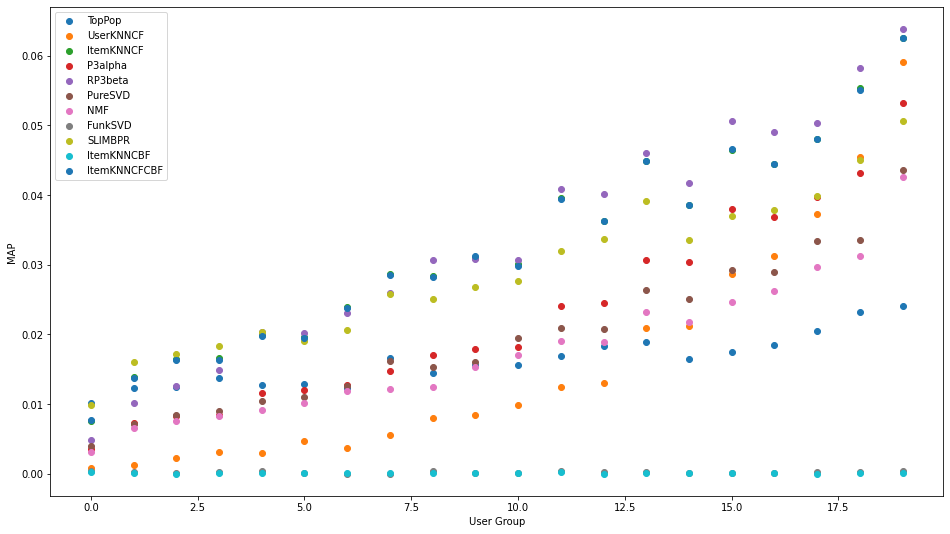

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [ ]:
MAP_recommender_per_group

{'TopPop': [0.010168580824437248,
  0.012272973264698669,
  0.01247095443892482,
  0.013753736192332689,
  0.012783724294967685,
  0.012894592943894449,
  0.012312550960268712,
  0.016523873947773157,
  0.014457881503667263,
  0.015578529919157645,
  0.015529340218552196,
  0.01684848927340018,
  0.018315971630084672,
  0.01891535950193333,
  0.01648812636684913,
  0.017399852778473616,
  0.018397769977053134,
  0.020441719608228888,
  0.023121277690423773,
  0.023988023502422556],
 'UserKNNCF': [0.0007495368704436714,
  0.0012478604530995173,
  0.0022517061960947216,
  0.003070894829666759,
  0.003016355357625198,
  0.004651353479244806,
  0.003652002453689459,
  0.005544566494145284,
  0.007907010762332058,
  0.008365712493954439,
  0.00981898723836379,
  0.012380324656498826,
  0.012948538873381765,
  0.020894277432611266,
  0.021224486066556716,
  0.028658050962251293,
  0.031246109928834642,
  0.037216443308658004,
  0.04541081483672902,
  0.059120997527812975],
 'ItemKNNCF': [0.0

# Item-based Collaborative Filtering

In [24]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender # better than ITEMKNN
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

## EASE_R

In [22]:
ease_recommender = EASE_R_Recommender(URM_train)
ease_recommender.fit()

result_df, _ = evaluator_validation.evaluateRecommender(ease_recommender)
result_df

EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 6.67 min
EvaluatorHoldout: Processed 37909 (100.0%) in 35.75 sec. Users per second: 1061


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.03036,0.077118,0.076057,0.013258,0.033712,0.106136,0.071394,0.043397,0.241051,0.118377,...,0.910639,0.21951,0.910639,0.007778,7.599012,0.987103,0.015321,0.563194,5.50232,0.239925


## P3Alpha

In [ ]:
P3alpha_recommender = P3alphaRecommender(URM_train)
P3alpha_recommender.fit()

result_df, _ = evaluator_validation.evaluateRecommender(P3alpha_recommender)
result_df

P3alphaRecommender: Similarity column 24507 (100.0%), 3090.59 column/sec. Elapsed time 7.93 sec
EvaluatorHoldout: Processed 40098 (100.0%) in 21.33 sec. Users per second: 1880


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.025241,0.044705,0.042411,0.012419,0.022293,0.096006,0.044167,0.031647,0.190508,0.108861,...,0.963223,0.183502,0.963223,0.19343,11.71247,0.998959,0.382046,0.868027,1.616416,0.343944


## RP3Beta

In [ ]:
RP3Beta_recommender = RP3betaRecommender(URM_train)
RP3Beta_recommender.fit()

result_df, _ = evaluator_validation.evaluateRecommender(RP3Beta_recommender)
result_df

RP3betaRecommender: Similarity column 24507 (100.0%), 1984.84 column/sec. Elapsed time 12.35 sec
EvaluatorHoldout: Processed 40085 (100.0%) in 32.97 sec. Users per second: 1216


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.038089,0.07095,0.068005,0.017364,0.032287,0.128335,0.06455,0.048829,0.277934,0.148659,...,0.96291,0.267626,0.96291,0.109319,10.360971,0.996245,0.21627,0.767993,3.115406,0.321209


## LightFactorizationMachines with WARP loss

WARP (Weighted Approximate-Rank Pairwise) loss maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

In [ ]:
# use the custom LightFM class of the lesson
## In order to evaluate put it in a recommender class
from Recommenders.BaseRecommender import BaseRecommender
from lightfm import LightFM

class LightFMCFRecommender(BaseRecommender):
    """LightFMCFRecommender"""

    RECOMMENDER_NAME = "LightFMCFRecommender"

    def __init__(self, URM_train):
        super(LightFMCFRecommender, self).__init__(URM_train)


    def fit(self, epochs = 300, alpha = 1e-6, n_factors = 10, n_threads = 4):
        
        # Let's fit a WARP model
        self.lightFM_model = LightFM(loss='warp',
                                     item_alpha=alpha,
                                     no_components=n_factors)

        self.lightFM_model = self.lightFM_model.fit(URM_train, 
                                       epochs=epochs,
                                       num_threads=n_threads)


    def _compute_item_score(self, user_id_array, items_to_compute = None):
        
        # Create a single (n_items, ) array with the item score, then copy it for every user
        items_to_compute = np.arange(self.n_items)
        
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf

        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index] = self.lightFM_model.predict(int(user_id), 
                                                                 items_to_compute)

        return item_scores

In [ ]:

LightFM_recommender = LightFMCFRecommender(URM_train)
LightFM_recommender.fit()

result_df, _ = evaluator_validation.evaluateRecommender(LightFM_recommender)
result_df

EvaluatorHoldout: Processed 40085 (100.0%) in 1.89 min. Users per second: 354


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.022215,0.040927,0.039025,0.009135,0.016845,0.073706,0.036022,0.028313,0.178546,0.081833,...,0.96291,0.171923,0.96291,0.014558,7.622214,0.981004,0.028802,0.564987,5.998907,0.274326


# SLIM BPR

In [ ]:
SLIM_recommender = SLIM_BPR_Python(URM_train)

In [ ]:
SLIM_recommender.fit(topK=154,
                     epochs=300,
                     lambda_i=0.24213692192305186,
                     lambda_j=0.5906404596327147,
                     learning_rate=0.019304915687303914)

Epoch 1, Iteration 41629 in 3.77 seconds. Samples per second 11031.95
Epoch 2, Iteration 41629 in 3.80 seconds. Samples per second 10963.91
Epoch 3, Iteration 41629 in 3.72 seconds. Samples per second 11201.57
Epoch 4, Iteration 41629 in 3.77 seconds. Samples per second 11030.36
Epoch 5, Iteration 41629 in 3.63 seconds. Samples per second 11479.37
Epoch 6, Iteration 41629 in 4.28 seconds. Samples per second 9720.78
Epoch 7, Iteration 41629 in 3.65 seconds. Samples per second 11398.29
Epoch 8, Iteration 41629 in 3.69 seconds. Samples per second 11282.25
Epoch 9, Iteration 41629 in 3.73 seconds. Samples per second 11146.86
Epoch 10, Iteration 41629 in 3.68 seconds. Samples per second 11322.49
Epoch 11, Iteration 41629 in 3.69 seconds. Samples per second 11291.04
Epoch 12, Iteration 41629 in 3.72 seconds. Samples per second 11180.25
Epoch 13, Iteration 41629 in 3.72 seconds. Samples per second 11203.91
Epoch 14, Iteration 41629 in 3.67 seconds. Samples per second 11344.13
Epoch 15, Iterat

In [ ]:
result_df, _ = evaluator_validation.evaluateRecommender(SLIM_recommender)
result_df

EvaluatorHoldout: Processed 40900 (100.0%) in 42.05 sec. Users per second: 973


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.027457,0.043671,0.040191,0.011268,0.017708,0.086139,0.03998,0.032626,0.211271,0.098125,...,0.982488,0.207572,0.982488,0.047316,9.754477,0.997711,0.093883,0.723131,1.850263,0.351927


# MF AsymmetricSVD

**Remember that for MF techniques, the prediction is computed by a dot product between ITEM_FACTORS and USER_FACTORS**

In [ ]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

recommender = PureSVDRecommender(URM_train)

In [ ]:
recommender.fit()

ASY_SVD: Estimating user factors... 
ASY_SVD: Estimating user factors... done!
ASY_SVD: Processed 994971 (100.0%) in 11.79 sec. MSE loss 1.47E-03. Sample per second: 84354
ASY_SVD: Epoch 1 of 300. Elapsed time 10.88 sec
ASY_SVD: Processed 994971 (100.0%) in 11.47 sec. MSE loss 9.22E-04. Sample per second: 86710
ASY_SVD: Epoch 2 of 300. Elapsed time 21.56 sec
ASY_SVD: Processed 994971 (100.0%) in 11.21 sec. MSE loss 8.87E-04. Sample per second: 88768
ASY_SVD: Epoch 3 of 300. Elapsed time 32.30 sec
ASY_SVD: Processed 994971 (100.0%) in 10.92 sec. MSE loss 8.59E-04. Sample per second: 91077
ASY_SVD: Epoch 4 of 300. Elapsed time 43.01 sec
ASY_SVD: Processed 994971 (100.0%) in 11.55 sec. MSE loss 8.34E-04. Sample per second: 86116
ASY_SVD: Epoch 5 of 300. Elapsed time 53.65 sec
ASY_SVD: Processed 994971 (100.0%) in 11.35 sec. MSE loss 8.13E-04. Sample per second: 87669
ASY_SVD: Epoch 6 of 300. Elapsed time 1.07 min
ASY_SVD: Processed 994971 (100.0%) in 11.08 sec. MSE loss 7.89E-04. Sample p

In [ ]:
result_df, _ = evaluator_validation.evaluateRecommender(recommender)

result_df

EvaluatorHoldout: Processed 40878 (100.0%) in 33.41 sec. Users per second: 1223


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.000115,0.000208,0.000194,0.000039,0.000071,0.000388,0.000174,0.000145,0.00115,0.000388,...,0.98196,0.001129,0.98196,0.031426,9.856738,0.997996,0.062382,0.730692,0.073573,0.482289


# MF IALS

In [17]:
from Recommenders.BaseMatrixFactorizationRecommender import BaseMatrixFactorizationRecommender
from implicit.als import AlternatingLeastSquares
import numpy as np
import os

class ALS(BaseMatrixFactorizationRecommender):

    RECOMMENDER_NAME = "ALS"

    def fit(self, factors=1024, regularization=0.01, iterations=50, alpha=5):
        
        sparse_item_user = self.URM_train.tocsr()

        os.environ['OPENBLAS_NUM_THREADS'] = '1'

        model = AlternatingLeastSquares(factors=factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        random_state=1234)
        
        data_confidence = (sparse_item_user * alpha).astype(np.float32)

        model.fit(data_confidence)
        
        self.USER_factors = model.user_factors.to_numpy()
        self.ITEM_factors = model.item_factors.to_numpy()

In [ ]:
IALS_recommender = ALS(URM_train)
IALS_recommender.fit()

IALSRecommender: Epoch 1 of 150. Elapsed time 3.73 sec
IALSRecommender: Epoch 2 of 150. Elapsed time 7.40 sec
IALSRecommender: Epoch 3 of 150. Elapsed time 11.05 sec
IALSRecommender: Epoch 4 of 150. Elapsed time 14.72 sec
IALSRecommender: Epoch 5 of 150. Elapsed time 18.38 sec
IALSRecommender: Epoch 6 of 150. Elapsed time 21.99 sec
IALSRecommender: Epoch 7 of 150. Elapsed time 25.63 sec
IALSRecommender: Epoch 8 of 150. Elapsed time 29.26 sec
IALSRecommender: Epoch 9 of 150. Elapsed time 32.92 sec
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 40863 (100.0%) in 29.60 sec. Users per second: 1380
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0320363, PRECISION_RECALL_MIN_DEN: 0.0501497, RECALL: 0.0459567, MAP: 0.0136492, MAP_MIN_DEN: 0.0211372, MRR: 0.1015125, NDCG: 0.0469024, F1: 0.0377542, HIT_RATE: 0.2375499, ARHR_ALL_HITS: 0.1171448, NOVELTY: 0.0039908, AVERAGE_POPULARITY: 0.2133922, DIVERSITY_MEAN_INTER_LIST: 0.9027825, DIVERSITY_HERFINDAHL: 0.9902760, COVERAGE_ITEM: 

KeyboardInterrupt: ignored

# **Re-compose the entire dataset**

In [130]:
URM_train_validation = URM_train + URM_validation

# Hyperparameter tuning

In [15]:
from skopt.space import Real, Categorical, Integer
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from HyperparameterTuning.run_hyperparameter_search import runHyperparameterSearch_Collaborative, runHyperparameterSearch_Hybrid

c:\users\ste_9\appdata\local\programs\python\python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [14]:
output_folder_path = "hyperparameter_tuning_experiments/"
# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 75  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP_MIN_DEN"
cutoff_to_optimize = 10

### Tuning user-wise

In [ ]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
block_size = int(len(profile_length)*0.05)
sorted_users = np.argsort(profile_length)

In [ ]:
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

recommender_object_dict = {}

recommender_object = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_type)
recommender_object.fit(topK=47, shrink=0, similarity="asymmetric", normalize=True, 
                       asymmetric_alpha=0.18336119820956812,
                       feature_weighting='TF-IDF',
                       ICM_weight=0.01) #hyperparameters gotten from tuning
recommender_object_dict["ItemKNNCFCBF"] = recommender_object

recommender_object = RP3betaRecommender(URM_train)
recommender_object.fit(topK=230,
                       alpha=0.5538028817676098, 
                       beta=0.3725401274854678,
                       normalize_similarity=True) #hyperparameters gotten from tuning
recommender_object_dict["RP3beta"] = recommender_object

recommender_object = SLIM_BPR_Cython(URM_train)
recommender_object.fit(topK=152,
                      epochs=15,
                      symmetric=True,
                      sgd_mode="adam",
                      lambda_i=0.00010512180320783175,
                      lambda_j=1.7963335714293517e-05,
                      learning_rate=0.004266357303944144) #hyperparameters gotten from tuning
recommender_object_dict["SLIMBPR"] = recommender_object


ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.
Similarity column 24507 (100.0%), 3272.85 column/sec. Elapsed time 7.49 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 1551.93 column/sec. Elapsed time 15.79 sec
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Available RAM is 10890.00 MB (83.87%) of 12985.00 MB, required is 2402.37 MB. Using dense matrix.
Processed 41629 (100.0%) in 1.00 sec. BPR loss is 1.97E-01. Sample per second: 41784
SLIM_BPR_Recommender: Epoch 1 of 15. Elapsed time 0.17 sec
Processed 41629 (100.0%) in 0.15 sec. BPR loss is 8.59E-01. Sample per second: 270300
SLIM_BPR_Recommender: Epoch 2 of 15. Elapsed time 0.32 sec
Processed 41629 (100.0%) in 0.31 sec. BPR loss is 1.53E+00. Sample per second: 133456
SLIM_BPR_Recommender: Epoch 3 of 15. Elapsed time 0.48 sec
Processed 41629 (100.0%) in 0.48 sec. BPR loss is 2.28E+00. Sample per second: 86914
SLIM_BPR_Recommender: Epoch 4 of 15. Elapsed time 0.65 sec
Pro

In [ ]:
cutoff = 10

MAP_recommender_per_group = {}

# we know that SLIM works better in the first 25% of users,
# ItemKNNCFCBF works better in the following 15% of users and
# RP3Beta works better in the last 60% of users.

groups = {"0": 10405, "10405": 16648, "16648": 41629}
for start, end in groups.items():
    
    start_pos = int(start)
    end_pos = end
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Number of users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP_MIN_DEN"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP_MIN_DEN"]]

Number of users in group 19, average p.len 10405.00, median 12.155886592984142, min 13.0, max 2
EvaluatorHoldout: Ignoring 923 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31224 Users
EvaluatorHoldout: Processed 9943 (100.0%) in 7.41 sec. Users per second: 1342
EvaluatorHoldout: Processed 9943 (100.0%) in 6.72 sec. Users per second: 1480
EvaluatorHoldout: Processed 9943 (100.0%) in 6.59 sec. Users per second: 1510
Number of users in group 19, average p.len 6243.00, median 16.795771263815475, min 17.0, max 15
EvaluatorHoldout: Ignoring 923 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 35386 Users
EvaluatorHoldout: Processed 6004 (100.0%) in 3.95 sec. Users per second: 1519
EvaluatorHoldout: Processed 6004 (100.0%) in 4.65 sec. Users per second: 1292
EvaluatorHoldout: Processed 6004 (100.0%) in 4.47 sec. Users per second: 1344
Number of users in group 19, average p.len 24981.00, median 35.70269404747608, min 28.0, max

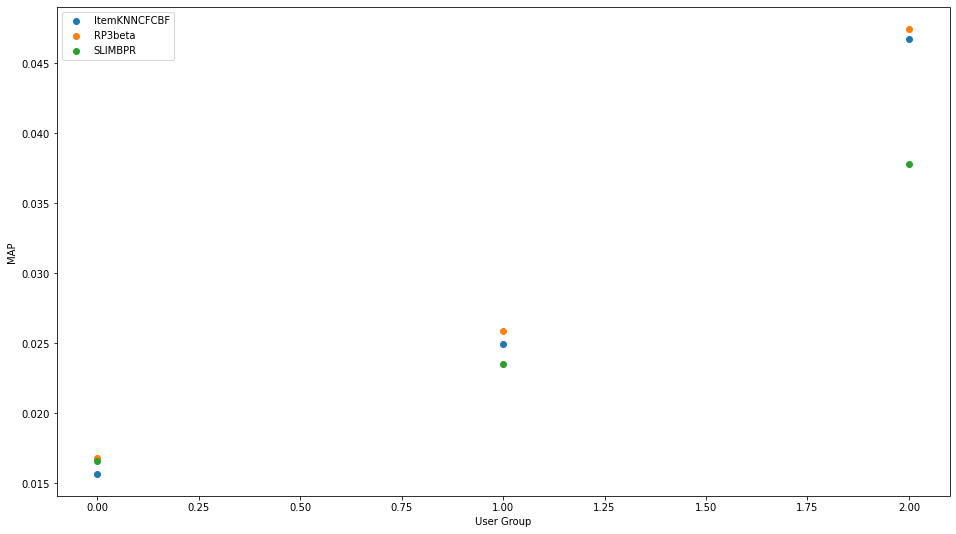

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### IALS

In [ ]:
hyperparameters_range_dictionary = {
    "factors": Integer(1, 1024),
    "regularization": Real(low = 1e-5, high = 1e-2, prior = 'log-uniform'),
    "iterations": Categorical([100]),
    "alpha": Real(low = 1e-3, high = 50.0, prior = 'log-uniform'),
}

recommender_class = ALS

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train],     
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation],   
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = n_random_starts,
                       save_model = "last",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                      )

### EASE 

In [31]:
class_recommender = EASE_R_Recommender

runHyperparameterSearch_Collaborative(class_recommender,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       n_cases = 22,
       n_random_starts = n_random_starts)

SearchBayesianSkopt: Resuming 'EASE_R_Recommender' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 44.57368158420745}
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 6.26 min
EvaluatorHoldout: Processed 37909 (100.0%) in 33.36 sec. Users per second: 1136
SearchBayesianSkopt: New best config found. Config 0: {'topK': None, 'normalize_matrix': False, 'l2_norm': 44.57368158420745} - results: PRECISION: 0.0329183, PRECISION_RECALL_MIN_DEN: 0.0820534, RECALL: 0.0808156, MAP: 0.0146362, MAP_MIN_DEN: 0.0366914, MRR: 0.1147206, NDCG: 0.0768243, F1: 0.0467813, HIT_RATE: 0.2553747, ARHR_ALL_HITS: 0.1292348, NOVELTY: 0.0041722, AVERAGE_POPULARITY: 0.2338718, DIVERSITY_MEAN_INTER_LIST: 0.9128997, DIVERSITY_HERFINDAHL: 0.9912876, COVERAGE_ITEM: 0.1224956, COVERAGE_ITEM_HIT: 0.0504346, ITEMS_IN_GT: 0.9563798, COVERAGE_USER: 0.9106392

C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\Recommenders\EASE_R\EASE_R_Recommender.py:73: RuntimeWarning: invalid value encountered in true_divide
  B = P / (-np.diag(P))


EASE_R_Recommender: Fitting model... done in 14.96 sec
EvaluatorHoldout: Processed 37909 (100.0%) in 22.40 sec. Users per second: 1692
SearchBayesianSkopt: Config 14 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 12646.448082119437} - results: PRECISION: 0.0000000, PRECISION_RECALL_MIN_DEN: 0.0000000, RECALL: 0.0000000, MAP: 0.0000000, MAP_MIN_DEN: 0.0000000, MRR: 0.0000000, NDCG: 0.0000000, F1: 0.0000000, HIT_RATE: 0.0000000, ARHR_ALL_HITS: 0.0000000, NOVELTY: 0.0000167, AVERAGE_POPULARITY: 0.0000496, DIVERSITY_MEAN_INTER_LIST: 1.0000189, DIVERSITY_HERFINDAHL: 0.8925360, COVERAGE_ITEM: 0.0009793, COVERAGE_ITEM_HIT: 0.0000000, ITEMS_IN_GT: 0.9563798, COVERAGE_USER: 0.0120349, COVERAGE_USER_HIT: 0.0000000, USERS_IN_GT: 0.9106392, DIVERSITY_GINI: 0.0003952, SHANNON_ENTROPY: 3.5209892, RATIO_DIVERSITY_HERFINDAHL: 0.8928310, RATIO_DIVERSITY_GINI: 0.0007785, RATIO_SHANNON_ENTROPY: 0.2609551, RATIO_AVERAGE_POPULARITY: 0.0009808, RATIO_NOVELTY: 0.0010002, 

Iterat

C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\Recommenders\EASE_R\EASE_R_Recommender.py:73: RuntimeWarning: invalid value encountered in true_divide
  B = P / (-np.diag(P))


EASE_R_Recommender: Fitting model... done in 17.24 sec
EvaluatorHoldout: Processed 37909 (100.0%) in 21.91 sec. Users per second: 1730
SearchBayesianSkopt: Config 15 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 414.5037308324497} - results: PRECISION: 0.0000000, PRECISION_RECALL_MIN_DEN: 0.0000000, RECALL: 0.0000000, MAP: 0.0000000, MAP_MIN_DEN: 0.0000000, MRR: 0.0000000, NDCG: 0.0000000, F1: 0.0000000, HIT_RATE: 0.0000000, ARHR_ALL_HITS: 0.0000000, NOVELTY: 0.0000167, AVERAGE_POPULARITY: 0.0000496, DIVERSITY_MEAN_INTER_LIST: 1.0000189, DIVERSITY_HERFINDAHL: 0.8925360, COVERAGE_ITEM: 0.0009793, COVERAGE_ITEM_HIT: 0.0000000, ITEMS_IN_GT: 0.9563798, COVERAGE_USER: 0.0120349, COVERAGE_USER_HIT: 0.0000000, USERS_IN_GT: 0.9106392, DIVERSITY_GINI: 0.0003952, SHANNON_ENTROPY: 3.5209892, RATIO_DIVERSITY_HERFINDAHL: 0.8928310, RATIO_DIVERSITY_GINI: 0.0007785, RATIO_SHANNON_ENTROPY: 0.2609551, RATIO_AVERAGE_POPULARITY: 0.0009808, RATIO_NOVELTY: 0.0010002, 

Iterati

C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\Recommenders\EASE_R\EASE_R_Recommender.py:73: RuntimeWarning: invalid value encountered in true_divide
  B = P / (-np.diag(P))


EASE_R_Recommender: Fitting model... done in 14.71 sec
EvaluatorHoldout: Processed 37909 (100.0%) in 21.94 sec. Users per second: 1728
SearchBayesianSkopt: Config 16 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 330.5255865717353} - results: PRECISION: 0.0000000, PRECISION_RECALL_MIN_DEN: 0.0000000, RECALL: 0.0000000, MAP: 0.0000000, MAP_MIN_DEN: 0.0000000, MRR: 0.0000000, NDCG: 0.0000000, F1: 0.0000000, HIT_RATE: 0.0000000, ARHR_ALL_HITS: 0.0000000, NOVELTY: 0.0000167, AVERAGE_POPULARITY: 0.0000496, DIVERSITY_MEAN_INTER_LIST: 1.0000189, DIVERSITY_HERFINDAHL: 0.8925360, COVERAGE_ITEM: 0.0009793, COVERAGE_ITEM_HIT: 0.0000000, ITEMS_IN_GT: 0.9563798, COVERAGE_USER: 0.0120349, COVERAGE_USER_HIT: 0.0000000, USERS_IN_GT: 0.9106392, DIVERSITY_GINI: 0.0003952, SHANNON_ENTROPY: 3.5209892, RATIO_DIVERSITY_HERFINDAHL: 0.8928310, RATIO_DIVERSITY_GINI: 0.0007785, RATIO_SHANNON_ENTROPY: 0.2609551, RATIO_AVERAGE_POPULARITY: 0.0009808, RATIO_NOVELTY: 0.0010002, 

Iterati

C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\Recommenders\EASE_R\EASE_R_Recommender.py:73: RuntimeWarning: invalid value encountered in true_divide
  B = P / (-np.diag(P))


EASE_R_Recommender: Fitting model... done in 16.32 sec
EvaluatorHoldout: Processed 37909 (100.0%) in 25.29 sec. Users per second: 1499
SearchBayesianSkopt: Config 17 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 497735.4912054936} - results: PRECISION: 0.0000000, PRECISION_RECALL_MIN_DEN: 0.0000000, RECALL: 0.0000000, MAP: 0.0000000, MAP_MIN_DEN: 0.0000000, MRR: 0.0000000, NDCG: 0.0000000, F1: 0.0000000, HIT_RATE: 0.0000000, ARHR_ALL_HITS: 0.0000000, NOVELTY: 0.0000167, AVERAGE_POPULARITY: 0.0000496, DIVERSITY_MEAN_INTER_LIST: 1.0000189, DIVERSITY_HERFINDAHL: 0.8925360, COVERAGE_ITEM: 0.0009793, COVERAGE_ITEM_HIT: 0.0000000, ITEMS_IN_GT: 0.9563798, COVERAGE_USER: 0.0120349, COVERAGE_USER_HIT: 0.0000000, USERS_IN_GT: 0.9106392, DIVERSITY_GINI: 0.0003952, SHANNON_ENTROPY: 3.5209892, RATIO_DIVERSITY_HERFINDAHL: 0.8928310, RATIO_DIVERSITY_GINI: 0.0007785, RATIO_SHANNON_ENTROPY: 0.2609551, RATIO_AVERAGE_POPULARITY: 0.0009808, RATIO_NOVELTY: 0.0010002, 

Iterati

### LightFM

In [ ]:
lightFM_recommender = LightFMCFRecommender

runHyperparameterSearch_Collaborative(lightFM_recommender,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

### P3Alpha

In [ ]:
recommenderP3Alpha = P3alphaRecommender

runHyperparameterSearch_Collaborative(recommenderP3Alpha,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

SearchBayesianSkopt: Extending previous number of cases from 12 to 40.

SearchBayesianSkopt: Resuming 'P3alphaRecommender'... Loaded 12 configurations.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5311
Function value obtained: -0.0294
Current minimum: -0.0314
Iteration No: 2 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 204, 'alpha': 0.09407063260406111, 'normalize_similarity': True}
P3alphaRecommender: Similarity column 24507 (100.0%), 2079.70 column/sec. Elapsed time 11.78 sec
EvaluatorHoldout: Processed 40056 (100.0%) in 21.93 sec. Users per second: 1826
SearchBayesianSkopt: New best config found. Config 12: {'topK': 204, 'alpha': 0.09407063260406111, 'normalize_similarity': True} - results: PRECISION: 0.0383288, PRECISION_RECALL_MIN_DEN: 0.0731755, RECALL: 0.0702301, MAP: 0.0169471, MAP_MIN_DEN: 0.0322324, MRR: 0.1263858, NDCG: 0.0648924, F1: 0.049592

### RP3Beta

In [140]:
recommenderRP3Beta = RP3betaRecommender

recommenderRP3Beta.RECOMMENDER_NAME = "RP3Beta_URM_tuned"

runHyperparameterSearch_Collaborative(RP3betaRecommender,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', "asymmetric"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

SearchBayesianSkopt: Resuming 'RP3Beta_URM_tuned' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 845, 'alpha': 1.1846877364724318, 'beta': 1.1892372204709996, 'normalize_similarity': True}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 661.55 column/sec. Elapsed time 37.04 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 34.32 sec. Users per second: 1107
SearchBayesianSkopt: New best config found. Config 0: {'topK': 845, 'alpha': 1.1846877364724318, 'beta': 1.1892372204709996, 'normalize_similarity': True} - results: PRECISION: 0.0032713, PRECISION_RECALL_MIN_DEN: 0.0066325, RECALL: 0.0063884, MAP: 0.0013370, MAP_MIN_DEN: 0.0026594, MRR: 0.0109584, NDCG: 0.0058155, F1: 0.0043269, HIT_RATE: 0.0271337, ARHR_ALL_HITS: 0.0120896, NOVELTY: 0.0065079, AVERAGE_POPULARITY: 0.0031102, DIVERSITY_MEAN_INTER_LIST: 0.9968333, DIVERSITY_HERFINDAHL: 0.9996807, COVERAGE_ITEM: 0.6229241, COVERAGE_ITEM_HIT:

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 1264.15 column/sec. Elapsed time 19.39 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 29.24 sec. Users per second: 1300
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'topK': 432, 'alpha': 0.30686723823475, 'beta': 1.7274612397616986, 'normalize_similarity': False} - results: PRECISION: 0.0008132, PRECISION_RECALL_MIN_DEN: 0.0016684, RECALL: 0.0015554, MAP: 0.0002979, MAP_MIN_DEN: 0.0005932, MRR: 0.0026745, NDCG: 0.0013262, F1: 0.0010680, HIT_RATE: 0.0073164, ARHR_ALL_HITS: 0.0028234, NOVELTY: 0.0067234, AVERAGE_POPULARITY: 0.0018813, DIVERSITY_MEAN_INTER_LIST: 0.9545918, DIVERSITY_HERFINDAHL: 0.9954567, COVERAGE_ITEM: 0.2813890, COVERAGE_ITEM_HIT: 0.0094259, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.0066780, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0339754, SHANNON_ENTROPY: 9.5279010, RATIO_DIVERSITY_HERFINDAHL: 0.9957842, RATIO_DIVERSITY_GINI: 0.0668817, RATIO_SHANNON_ENTROPY: 0.7060604, RATI

RP3Beta_URM_tuned: Saving complete
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 56.9245
Function value obtained: -0.0344
Current minimum: -0.0344
Iteration No: 10 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 993, 'alpha': 1.806651196597085, 'beta': 1.9308744682722763, 'normalize_similarity': True}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 756.71 column/sec. Elapsed time 32.39 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 39.05 sec. Users per second: 973
SearchBayesianSkopt: Config 9 is suboptimal. Config: {'topK': 993, 'alpha': 1.806651196597085, 'beta': 1.9308744682722763, 'normalize_similarity': True} - results: PRECISION: 0.0000895, PRECISION_RECALL_MIN_DEN: 0.0002927, RECALL: 0.0002859, MAP: 0.0000264, MAP_MIN_DEN: 0.0001015, MRR: 0.0002635, NDCG: 0.0001795, F1: 0.0001363, HIT_RATE: 0.0008948, ARHR_ALL_HITS: 0.0002635, NOVELTY: 0.0065937, AVERAGE_POPULARITY: 0.0023169, DIVERSITY_MEAN_INTER_LIST: 0.

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 82.0681
Function value obtained: -0.0297
Current minimum: -0.0344
Iteration No: 16 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 108, 'alpha': 1.4508111714581233, 'beta': 1.3364419547298816, 'normalize_similarity': True}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 2526.04 column/sec. Elapsed time 9.70 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 23.18 sec. Users per second: 1639
SearchBayesianSkopt: Config 15 is suboptimal. Config: {'topK': 108, 'alpha': 1.4508111714581233, 'beta': 1.3364419547298816, 'normalize_similarity': True} - results: PRECISION: 0.0012238, PRECISION_RECALL_MIN_DEN: 0.0030244, RECALL: 0.0029770, MAP: 0.0005035, MAP_MIN_DEN: 0.0012239, MRR: 0.0045939, NDCG: 0.0025686, F1: 0.0017345, HIT_RATE: 0.0112904, ARHR_ALL_HITS: 0.0048104, NOVELTY: 0.0065665, AVERAGE_POPULARITY: 0.0025346, DIVERSITY_MEAN_INTER_LIST: 0.9930786, DIVERSITY_HERFINDAHL:

Iteration No: 21 ended. Evaluation done at random point.
Time taken: 82.4032
Function value obtained: -0.0007
Current minimum: -0.0344
Iteration No: 22 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 964, 'alpha': 1.0956144541962747, 'beta': 1.941089250599886, 'normalize_similarity': False}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 769.99 column/sec. Elapsed time 31.83 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 44.35 sec. Users per second: 857
SearchBayesianSkopt: Config 21 is suboptimal. Config: {'topK': 964, 'alpha': 1.0956144541962747, 'beta': 1.941089250599886, 'normalize_similarity': False} - results: PRECISION: 0.0002527, PRECISION_RECALL_MIN_DEN: 0.0005306, RECALL: 0.0004745, MAP: 0.0000754, MAP_MIN_DEN: 0.0001579, MRR: 0.0006726, NDCG: 0.0003569, F1: 0.0003297, HIT_RATE: 0.0023160, ARHR_ALL_HITS: 0.0007105, NOVELTY: 0.0066378, AVERAGE_POPULARITY: 0.0021379, DIVERSITY_MEAN_INTER_LIST: 0.9922108, DIVERSITY_HERFINDAHL: 

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 27.7733
Function value obtained: -0.0266
Current minimum: -0.0344
Iteration No: 28 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 702, 'alpha': 1.8945435877249983, 'beta': 0.6652606129418193, 'normalize_similarity': True}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 928.56 column/sec. Elapsed time 26.39 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 32.98 sec. Users per second: 1152
SearchBayesianSkopt: Config 27 is suboptimal. Config: {'topK': 702, 'alpha': 1.8945435877249983, 'beta': 0.6652606129418193, 'normalize_similarity': True} - results: PRECISION: 0.0208674, PRECISION_RECALL_MIN_DEN: 0.0468436, RECALL: 0.0459054, MAP: 0.0089122, MAP_MIN_DEN: 0.0197105, MRR: 0.0682119, NDCG: 0.0416854, F1: 0.0286921, HIT_RATE: 0.1604864, ARHR_ALL_HITS: 0.0778752, NOVELTY: 0.0056527, AVERAGE_POPULARITY: 0.0870107, DIVERSITY_MEAN_INTER_LIST: 0.9827685, DIVERSITY

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 81.6934
Function value obtained: -0.0295
Current minimum: -0.0344
Iteration No: 34 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 1000, 'alpha': 0.49883518334250976, 'beta': 0.3599100778948565, 'normalize_similarity': True}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 767.29 column/sec. Elapsed time 31.94 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 33.06 sec. Users per second: 1149
SearchBayesianSkopt: Config 33 is suboptimal. Config: {'topK': 1000, 'alpha': 0.49883518334250976, 'beta': 0.3599100778948565, 'normalize_similarity': True} - results: PRECISION: 0.0294813, PRECISION_RECALL_MIN_DEN: 0.0745364, RECALL: 0.0735223, MAP: 0.0129658, MAP_MIN_DEN: 0.0326882, MRR: 0.1034323, NDCG: 0.0643811, F1: 0.0420865, HIT_RATE: 0.2335184, ARHR_ALL_HITS: 0.1156076, NOVELTY: 0.0040752, AVERAGE_POPULARITY: 0.2946630, DIVERSITY_MEAN_INTER_LIST: 0.8251035, DIVER

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 74.1687
Function value obtained: -0.0298
Current minimum: -0.0344
Iteration No: 40 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 5, 'alpha': 1.5296737968657372, 'beta': 0.41040223718810037, 'normalize_similarity': True}
RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 3862.68 column/sec. Elapsed time 6.34 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 20.32 sec. Users per second: 1870
SearchBayesianSkopt: Config 39 is suboptimal. Config: {'topK': 5, 'alpha': 1.5296737968657372, 'beta': 0.41040223718810037, 'normalize_similarity': True} - results: PRECISION: 0.0233624, PRECISION_RECALL_MIN_DEN: 0.0562418, RECALL: 0.0552821, MAP: 0.0112362, MAP_MIN_DEN: 0.0275488, MRR: 0.0923315, NDCG: 0.0530496, F1: 0.0328445, HIT_RATE: 0.1900676, ARHR_ALL_HITS: 0.1017163, NOVELTY: 0.0053492, AVERAGE_POPULARITY: 0.0774454, DIVERSITY_MEAN_INTER_LIST: 0.9896470, DIVERSITY_H

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 884.28 column/sec. Elapsed time 27.71 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 31.72 sec. Users per second: 1198
SearchBayesianSkopt: Config 43 is suboptimal. Config: {'topK': 747, 'alpha': 0.0, 'beta': 0.39975559472783057, 'normalize_similarity': True} - results: PRECISION: 0.0301103, PRECISION_RECALL_MIN_DEN: 0.0756803, RECALL: 0.0746181, MAP: 0.0134026, MAP_MIN_DEN: 0.0334077, MRR: 0.1061075, NDCG: 0.0655029, F1: 0.0429066, HIT_RATE: 0.2373608, ARHR_ALL_HITS: 0.1189860, NOVELTY: 0.0041813, AVERAGE_POPULARITY: 0.2568141, DIVERSITY_MEAN_INTER_LIST: 0.8754858, DIVERSITY_HERFINDAHL: 0.9875463, COVERAGE_ITEM: 0.4633370, COVERAGE_ITEM_HIT: 0.0387644, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2166519, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0287106, SHANNON_ENTROPY: 8.2846899, RATIO_DIVERSITY_HERFINDAHL: 0.9878712, RATIO_DIVERSITY_GINI: 0.0565178, RATIO_SHANNON_ENTROPY: 0.6139328, RATIO_AVERAGE_POP

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 998.89 column/sec. Elapsed time 24.53 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 33.44 sec. Users per second: 1136
SearchBayesianSkopt: Config 49 is suboptimal. Config: {'topK': 661, 'alpha': 1.326669894099317, 'beta': 0.3986544199403113, 'normalize_similarity': True} - results: PRECISION: 0.0290865, PRECISION_RECALL_MIN_DEN: 0.0735756, RECALL: 0.0725866, MAP: 0.0127248, MAP_MIN_DEN: 0.0319980, MRR: 0.1013749, NDCG: 0.0635131, F1: 0.0415309, HIT_RATE: 0.2304129, ARHR_ALL_HITS: 0.1133663, NOVELTY: 0.0042812, AVERAGE_POPULARITY: 0.2759002, DIVERSITY_MEAN_INTER_LIST: 0.8383497, DIVERSITY_HERFINDAHL: 0.9838328, COVERAGE_ITEM: 0.6019097, COVERAGE_ITEM_HIT: 0.0328478, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2103101, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0577340, SHANNON_ENTROPY: 8.4904350, RATIO_DIVERSITY_HERFINDAHL: 0.9841565, RATIO_DIVERSITY_GINI: 0.1136514, RATIO_SHANNON_ENTROPY: 0.6291795, RATI

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 811.27 column/sec. Elapsed time 30.21 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 31.67 sec. Users per second: 1200
SearchBayesianSkopt: Config 55 is suboptimal. Config: {'topK': 971, 'alpha': 1.1065701920448745, 'beta': 0.2960395273790046, 'normalize_similarity': True} - results: PRECISION: 0.0285786, PRECISION_RECALL_MIN_DEN: 0.0726148, RECALL: 0.0716439, MAP: 0.0123219, MAP_MIN_DEN: 0.0312408, MRR: 0.0988820, NDCG: 0.0621602, F1: 0.0408587, HIT_RATE: 0.2281496, ARHR_ALL_HITS: 0.1101900, NOVELTY: 0.0040774, AVERAGE_POPULARITY: 0.3082501, DIVERSITY_MEAN_INTER_LIST: 0.7981079, DIVERSITY_HERFINDAHL: 0.9798087, COVERAGE_ITEM: 0.5544538, COVERAGE_ITEM_HIT: 0.0301955, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2082443, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0369560, SHANNON_ENTROPY: 7.7495280, RATIO_DIVERSITY_HERFINDAHL: 0.9801311, RATIO_DIVERSITY_GINI: 0.0727492, RATIO_SHANNON_ENTROPY: 0.5742749, RAT

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 797.71 column/sec. Elapsed time 30.72 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 29.39 sec. Users per second: 1293
SearchBayesianSkopt: Config 61 is suboptimal. Config: {'topK': 1000, 'alpha': 0.7353239064712193, 'beta': 0.0, 'normalize_similarity': True} - results: PRECISION: 0.0275048, PRECISION_RECALL_MIN_DEN: 0.0698469, RECALL: 0.0688989, MAP: 0.0115325, MAP_MIN_DEN: 0.0291785, MRR: 0.0932863, NDCG: 0.0586450, F1: 0.0393149, HIT_RATE: 0.2214122, ARHR_ALL_HITS: 0.1035518, NOVELTY: 0.0038324, AVERAGE_POPULARITY: 0.3351075, DIVERSITY_MEAN_INTER_LIST: 0.7735418, DIVERSITY_HERFINDAHL: 0.9773521, COVERAGE_ITEM: 0.0704289, COVERAGE_ITEM_HIT: 0.0223610, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2020947, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0042102, SHANNON_ENTROPY: 6.6556099, RATIO_DIVERSITY_HERFINDAHL: 0.9776737, RATIO_DIVERSITY_GINI: 0.0082879, RATIO_SHANNON_ENTROPY: 0.4932107, RATIO_AVERAGE_POP

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 1292.24 column/sec. Elapsed time 18.96 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 28.82 sec. Users per second: 1319
SearchBayesianSkopt: Config 67 is suboptimal. Config: {'topK': 463, 'alpha': 1.0331819751225435, 'beta': 0.4580180513731574, 'normalize_similarity': True} - results: PRECISION: 0.0303103, PRECISION_RECALL_MIN_DEN: 0.0766581, RECALL: 0.0756299, MAP: 0.0135476, MAP_MIN_DEN: 0.0340224, MRR: 0.1076342, NDCG: 0.0668320, F1: 0.0432766, HIT_RATE: 0.2387557, ARHR_ALL_HITS: 0.1205319, NOVELTY: 0.0042621, AVERAGE_POPULARITY: 0.2608590, DIVERSITY_MEAN_INTER_LIST: 0.8640374, DIVERSITY_HERFINDAHL: 0.9864015, COVERAGE_ITEM: 0.6207206, COVERAGE_ITEM_HIT: 0.0362345, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2179250, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0530463, SHANNON_ENTROPY: 8.5572445, RATIO_DIVERSITY_HERFINDAHL: 0.9867260, RATIO_DIVERSITY_GINI: 0.1044236, RATIO_SHANNON_ENTROPY: 0.6341304, RA

RP3Beta_URM_tuned: Similarity column 24507 (100.0%), 1781.35 column/sec. Elapsed time 13.76 sec
EvaluatorHoldout: Processed 37997 (100.0%) in 22.32 sec. Users per second: 1702
SearchBayesianSkopt: Config 73 is suboptimal. Config: {'topK': 290, 'alpha': 0.0, 'beta': 0.0, 'normalize_similarity': True} - results: PRECISION: 0.0307919, PRECISION_RECALL_MIN_DEN: 0.0770527, RECALL: 0.0759355, MAP: 0.0133349, MAP_MIN_DEN: 0.0328852, MRR: 0.1047288, NDCG: 0.0652936, F1: 0.0438163, HIT_RATE: 0.2414927, ARHR_ALL_HITS: 0.1179239, NOVELTY: 0.0041211, AVERAGE_POPULARITY: 0.2344741, DIVERSITY_MEAN_INTER_LIST: 0.9066984, DIVERSITY_HERFINDAHL: 0.9906675, COVERAGE_ITEM: 0.1246175, COVERAGE_ITEM_HIT: 0.0363162, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2204233, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0105541, SHANNON_ENTROPY: 8.0099741, RATIO_DIVERSITY_HERFINDAHL: 0.9909934, RATIO_DIVERSITY_GINI: 0.0207762, RATIO_SHANNON_ENTROPY: 0.5935752, RATIO_AVERAGE_POPULARITY: 4.6245

### CFItemKNN

In [ ]:
recommenderItemKNN = ItemKNNCFRecommender
recommenderItemKNN.RECOMMENDER_NAME = "ItemKNNCF_URM_tuned"
runHyperparameterSearch_Collaborative(recommenderItemKNN,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', "asymmetric"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

### Hybrid_ItemKNNCFCBF

In [ ]:
recommenderKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender

runHyperparameterSearch_Hybrid(recommenderKNNCFCBF,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       ICM_object = ICM_type,
       ICM_name = "ICM_series_types",
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

SearchBayesianSkopt: Resuming 'ItemKNN_CFCBF_HybridRecommender_ICM_series_types_cosine' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 75, 'shrink': 938, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'none', 'ICM_weight': 0.03607677523482769}
ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.
SearchBayesianSkopt: Resuming 'ItemKNN_CFCBF_HybridRecommender_ICM_series_types_jaccard' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 988, 'shrink': 453, 'similarity': 'jaccard', 'normalize': True, 'ICM_weight': 0.01020671096168889}

ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.Similarity column 24507 (100.0%), 1778.50 column/sec. Elapsed time 13.78 sec
Similarity column 24507 (100.0%), 1752.35 column/sec. Elapsed time 13.99 sec
Ev

### MF IALS (Un-tunable zioccane)

In [ ]:
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
recommenderMFIALS = IALSRecommender

runHyperparameterSearch_Collaborative(recommenderMFIALS,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

SearchBayesianSkopt: Resuming 'IALSRecommender' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'num_factors': 68, 'epochs': 300, 'confidence_scaling': 'linear', 'alpha': 0.0695343399349595, 'epsilon': 3.626137590652313, 'reg': 0.0024701486638937196}
IALSRecommender: Epoch 1 of 300. Elapsed time 18.48 sec
IALSRecommender: Epoch 2 of 300. Elapsed time 37.54 sec
IALSRecommender: Epoch 3 of 300. Elapsed time 55.22 sec
IALSRecommender: Epoch 4 of 300. Elapsed time 1.22 min
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 40126 (100.0%) in 34.14 sec. Users per second: 1175
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0242636, PRECISION_RECALL_MIN_DEN: 0.0447706, RECALL: 0.0425863, MAP: 0.0105952, MAP_MIN_DEN: 0.0195047, MRR: 0.0834132, NDCG: 0.0404445, F1: 0.0309139, HIT_RATE: 0.1905747, ARHR_ALL_HITS: 0.0936197, NOVELTY: 0.0042397, AVERAGE_POPULARITY: 0.1343166, DIVERSITY_MEAN_INTER_LIST: 0.942

KeyboardInterrupt: ignored

### SLIM BPR

In [ ]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

recommenderSLIMBPR = SLIM_BPR_Cython

runHyperparameterSearch_Collaborative(recommenderSLIMBPR,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', "asymmetric"],
       n_cases = 1,
       n_random_starts = n_random_starts)

Deallocating Cython objects
SearchBayesianSkopt: Resuming 'SLIM_BPR_Recommender'... Loaded 2 configurations.
SearchBayesianSkopt: Evaluation with constructor data for final test. Using best config: {'topK': 152, 'epochs': 15, 'symmetric': True, 'sgd_mode': 'adam', 'lambda_i': 0.00010512180320783175, 'lambda_j': 1.7963335714293517e-05, 'learning_rate': 0.004266357303944144}
Processed 41629 (100.0%) in 0.52 sec. BPR loss is 3.33E-01. Sample per second: 80669
SLIM_BPR_Recommender: Epoch 1 of 15. Elapsed time 0.18 sec
Processed 41629 (100.0%) in 0.70 sec. BPR loss is 1.48E+00. Sample per second: 59365
SLIM_BPR_Recommender: Epoch 2 of 15. Elapsed time 0.36 sec
Processed 41629 (100.0%) in 0.88 sec. BPR loss is 2.58E+00. Sample per second: 47171
SLIM_BPR_Recommender: Epoch 3 of 15. Elapsed time 0.55 sec
Processed 41629 (100.0%) in 1.08 sec. BPR loss is 3.67E+00. Sample per second: 38704
SLIM_BPR_Recommender: Epoch 4 of 15. Elapsed time 0.74 sec
Processed 41629 (100.0%) in 0.25 sec. BPR loss i

### CollaborativeHyperParameterSearch

In [ ]:
from functools import partial

runHyperparameterSearch_Collaborative_partial = partial(runHyperparameterSearch_Collaborative,
       URM_train = URM_train,
       URM_train_last_test = URM_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)

In [ ]:
collaborative_algorithm_list = [
    ItemKNNCFRecommender,
    RP3betaRecommender,
    P3alphaRecommender,
]

In [ ]:
for recommender_class in collaborative_algorithm_list:
    try:
        runHyperparameterSearch_Collaborative_partial(recommender_class)
    except Exception as e:

        print("On recommender {} Exception {}".format(recommender_class, str(e)))
        traceback.print_exc()

SearchBayesianSkopt: Extending previous number of cases from 40 to 100.

SearchBayesianSkopt: Resuming 'ItemKNNCFRecommender_cosine'... Loaded 40 configurations.
Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Extending previous number of cases from 40 to 100.

SearchBayesianSkopt: Resuming 'ItemKNNCFRecommender_jaccard'... Loaded 40 configurations.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3156
Function value obtained: -0.0102
Current minimum: -0.0320
Iteration No: 2 started. Evaluating function at random point.


/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


SearchBayesianSkopt: Testing config: {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'}
SearchBayesianSkopt: Config 40 was already explored at index 22. Config: {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'} - results: PRECISION: 0.0370082, PRECISION_RECALL_MIN_DEN: 0.0711086, RECALL: 0.0682694, MAP: 0.0167140, MAP_MIN_DEN: 0.0318263, MRR: 0.1251671, NDCG: 0.0636242, F1: 0.0479974, HIT_RATE: 0.2747903, ARHR_ALL_HITS: 0.1441011, NOVELTY: 0.0043138, AVERAGE_POPULARITY: 0.2300788, DIVERSITY_MEAN_INTER_LIST: 0.9028442, DIVERSITY_HERFINDAHL: 0.9902822, COVERAGE_ITEM: 0.6501816, COVERAGE_ITEM_HIT: 0.0423961, ITEMS_IN_GT: 0.9863712, COVERAGE_USER: 0.9622138, COVERAGE_USER_HIT: 0.2644070, USERS_IN_GT: 0.9622138, DIVERSITY_GINI: 0.0490929, SHANNON_ENTROPY: 8.7639569, RATIO_DIVERSITY_HERFINDAHL: 0.9906093, RATIO_DIVERSITY_GINI: 0.0970140, RATIO_SHANNON_ENTROPY: 0.6495788, RATIO_AVERAGE_POPUL

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


SearchBayesianSkopt: Testing config: {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'}
SearchBayesianSkopt: Config 53 was already explored at index 22. Config: {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'} - results: PRECISION: 0.0370082, PRECISION_RECALL_MIN_DEN: 0.0711086, RECALL: 0.0682694, MAP: 0.0167140, MAP_MIN_DEN: 0.0318263, MRR: 0.1251671, NDCG: 0.0636242, F1: 0.0479974, HIT_RATE: 0.2747903, ARHR_ALL_HITS: 0.1441011, NOVELTY: 0.0043138, AVERAGE_POPULARITY: 0.2300788, DIVERSITY_MEAN_INTER_LIST: 0.9028442, DIVERSITY_HERFINDAHL: 0.9902822, COVERAGE_ITEM: 0.6501816, COVERAGE_ITEM_HIT: 0.0423961, ITEMS_IN_GT: 0.9863712, COVERAGE_USER: 0.9622138, COVERAGE_USER_HIT: 0.2644070, USERS_IN_GT: 0.9622138, DIVERSITY_GINI: 0.0490929, SHANNON_ENTROPY: 8.7639569, RATIO_DIVERSITY_HERFINDAHL: 0.9906093, RATIO_DIVERSITY_GINI: 0.0970140, RATIO_SHANNON_ENTROPY: 0.6495788, RATIO_AVERAGE_POPUL

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


SearchBayesianSkopt: Testing config: {'topK': 756, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'}
SearchBayesianSkopt: Config 74 was already explored at index 58. Config: {'topK': 756, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'} - results: PRECISION: 0.0372935, PRECISION_RECALL_MIN_DEN: 0.0715623, RECALL: 0.0687237, MAP: 0.0168381, MAP_MIN_DEN: 0.0319402, MRR: 0.1252905, NDCG: 0.0639092, F1: 0.0483496, HIT_RATE: 0.2756452, ARHR_ALL_HITS: 0.1446869, NOVELTY: 0.0043244, AVERAGE_POPULARITY: 0.2233661, DIVERSITY_MEAN_INTER_LIST: 0.9058195, DIVERSITY_HERFINDAHL: 0.9905797, COVERAGE_ITEM: 0.6560983, COVERAGE_ITEM_HIT: 0.0435386, ITEMS_IN_GT: 0.9860856, COVERAGE_USER: 0.9624541, COVERAGE_USER_HIT: 0.2652958, USERS_IN_GT: 0.9624541, DIVERSITY_GINI: 0.0502681, SHANNON_ENTROPY: 8.8119907, RATIO_DIVERSITY_HERFINDAHL: 0.9909080, RATIO_DIVERSITY_GINI: 0.0993119, RATIO_SHANNON_ENTROPY: 0.6531934, RATIO_AVERAGE_POPULAR

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


SearchBayesianSkopt: Testing config: {'topK': 587, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'}
SearchBayesianSkopt: Config 83 was already explored at index 82. Config: {'topK': 587, 'shrink': 0, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'} - results: PRECISION: 0.0374282, PRECISION_RECALL_MIN_DEN: 0.0718696, RECALL: 0.0690028, MAP: 0.0168932, MAP_MIN_DEN: 0.0320006, MRR: 0.1255441, NDCG: 0.0640762, F1: 0.0485320, HIT_RATE: 0.2764439, ARHR_ALL_HITS: 0.1450493, NOVELTY: 0.0043322, AVERAGE_POPULARITY: 0.2201814, DIVERSITY_MEAN_INTER_LIST: 0.9088232, DIVERSITY_HERFINDAHL: 0.9908801, COVERAGE_ITEM: 0.6575672, COVERAGE_ITEM_HIT: 0.0437834, ITEMS_IN_GT: 0.9860856, COVERAGE_USER: 0.9624541, COVERAGE_USER_HIT: 0.2660645, USERS_IN_GT: 0.9624541, DIVERSITY_GINI: 0.0504844, SHANNON_ENTROPY: 8.8484423, RATIO_DIVERSITY_HERFINDAHL: 0.9912084, RATIO_DIVERSITY_GINI: 0.0997391, RATIO_SHANNON_ENTROPY: 0.6558954, RATIO_AVERAGE_POPULAR

### The metadata.zip file contains details on the search

* RECOMMENDER_NAME + "_best_model.zip": contains the model trained on the URM_train
* RECOMMENDER_NAME + "_best_model_last.zip": contains the model trained on the URM_train_validation

In [12]:
from Recommenders.DataIO import DataIO

In [16]:
#from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

#EASE_R_Recommender
#ItemKNN_CFCBF_HybridRecommender_ICM_series_types_asymmetric 
#ItemKNNCFRecommender_asymmetric
#ItemKNNCFRecommender_cosine
#ItemKNNCFRecommender_jaccard
#ItemKNNCFRecommender_dice
#ItemKNNCFRecommender_tversky
#recommenderRP3Beta.RECOMMENDER_NAME
#recommenderP3Alpha.RECOMMENDER_NAME

data_loader = DataIO(folder_path = output_folder_path)
search_metadata_ITEMKNN_asymm = data_loader.load_data("ItemKNNCFRecommender_asymmetric_metadata.zip")

#search_metadata_ItemKNN.keys()
result_on_validation_df = search_metadata_ITEMKNN_asymm["result_on_validation_best"]
result_on_validation_df

{'PRECISION': 0.03890830130284698,
 'PRECISION_RECALL_MIN_DEN': 0.07422964410310187,
 'RECALL': 0.0712107976083499,
 'MAP': 0.017757654235590458,
 'MAP_MIN_DEN': 0.03349616143252753,
 'MRR': 0.1307682106270683,
 'NDCG': 0.06664969216680393,
 'F1': 0.050321718879957344,
 'HIT_RATE': 0.28313283082913193,
 'ARHR_ALL_HITS': 0.15172999273421067,
 'NOVELTY': 0.004423734330822793,
 'AVERAGE_POPULARITY': 0.17670340374227808,
 'DIVERSITY_MEAN_INTER_LIST': 0.9532147192375312,
 'DIVERSITY_HERFINDAHL': 0.9953190928124886,
 'COVERAGE_ITEM': 0.29420165666952297,
 'COVERAGE_ITEM_HIT': 0.051985147100828334,
 'ITEMS_IN_GT': 0.9860856081935774,
 'COVERAGE_USER': 0.9624540584688559,
 'COVERAGE_USER_HIT': 0.27250234211727403,
 'USERS_IN_GT': 0.9624540584688559,
 'DIVERSITY_GINI': 0.02946081209353677,
 'SHANNON_ENTROPY': 9.332756486270716,
 'RATIO_DIVERSITY_HERFINDAHL': 0.995648923419067,
 'RATIO_DIVERSITY_GINI': 0.05820403977292734,
 'RATIO_SHANNON_ENTROPY': 0.6917954079072872,
 'RATIO_AVERAGE_POPULARITY'

In [17]:
best_hpItem = search_metadata_ITEMKNN_asymm["hyperparameters_best"]
best_hpItem

{'topK': 24,
 'shrink': 19,
 'similarity': 'asymmetric',
 'normalize': True,
 'asymmetric_alpha': 0.21104539434421726,
 'feature_weighting': 'none'}

In [139]:
best_hpItem = search_metadata_ITEMKNN_cos["hyperparameters_best"]
best_hpItem

{'topK': 181,
 'shrink': 22,
 'similarity': 'cosine',
 'normalize': True,
 'feature_weighting': 'TF-IDF'}

In [141]:
#THIS IS RP3BETA tuned on tuned URM
search_metadata_RP3Beta = data_loader.load_data(recommenderRP3Beta.RECOMMENDER_NAME+"_metadata.zip")

#search_metadata_P3alpha.keys()
result_on_validation_df = search_metadata_RP3Beta["result_on_validation_best"]
result_on_validation_df

{'PRECISION': 0.03218938337237181,
 'PRECISION_RECALL_MIN_DEN': 0.08082645204654855,
 'RECALL': 0.07966170814393503,
 'MAP': 0.014350823853679681,
 'MAP_MIN_DEN': 0.035762147597110626,
 'MRR': 0.11254887081728752,
 'NDCG': 0.07012050544263791,
 'F1': 0.045851340899418454,
 'HIT_RATE': 0.25104613522120167,
 'ARHR_ALL_HITS': 0.12684163453171624,
 'NOVELTY': 0.0042994993890609744,
 'AVERAGE_POPULARITY': 0.22065935732594918,
 'DIVERSITY_MEAN_INTER_LIST': 0.9187352054985043,
 'DIVERSITY_HERFINDAHL': 0.9918711026347374,
 'COVERAGE_ITEM': 0.5300118333537357,
 'COVERAGE_ITEM_HIT': 0.0400293793609989,
 'ITEMS_IN_GT': 0.9536867017586812,
 'COVERAGE_USER': 0.9127531288284609,
 'COVERAGE_USER_HIT': 0.22914314540344471,
 'USERS_IN_GT': 0.9127531288284609,
 'DIVERSITY_GINI': 0.03865315228364584,
 'SHANNON_ENTROPY': 8.818427097926426,
 'RATIO_DIVERSITY_HERFINDAHL': 0.9921974522554501,
 'RATIO_DIVERSITY_GINI': 0.0760901136299241,
 'RATIO_SHANNON_ENTROPY': 0.6534851716879241,
 'RATIO_AVERAGE_POPULARITY

In [142]:
search_metadata_RP3Beta["hyperparameters_best"]

{'topK': 126,
 'alpha': 1.063016817555952,
 'beta': 0.2961108823741472,
 'normalize_similarity': True}

In [21]:
data_loader = DataIO(folder_path = output_folder_path)
search_metadata_RP3beta = data_loader.load_data("RP3betaRecommender_metadata.zip")

#search_metadata_RP3beta.keys()
result_on_validation_df = search_metadata_RP3beta["result_on_validation_best"]
result_on_validation_df

{'PRECISION': 0.03969844236759745,
 'PRECISION_RECALL_MIN_DEN': 0.07623836226079066,
 'RECALL': 0.07322225773281825,
 'MAP': 0.01808218365227684,
 'MAP_MIN_DEN': 0.0346922450863347,
 'MRR': 0.1335809424912218,
 'NDCG': 0.06852736788158817,
 'F1': 0.05148408708140752,
 'HIT_RATE': 0.2893707165109034,
 'ARHR_ALL_HITS': 0.1547539830885615,
 'NOVELTY': 0.0043260811536897596,
 'AVERAGE_POPULARITY': 0.22271878250402843,
 'DIVERSITY_MEAN_INTER_LIST': 0.9158409626730344,
 'DIVERSITY_HERFINDAHL': 0.9915818137976146,
 'COVERAGE_ITEM': 0.6829477292202228,
 'COVERAGE_ITEM_HIT': 0.04529318153996817,
 'ITEMS_IN_GT': 0.9861672175296854,
 'COVERAGE_USER': 0.9638713396910807,
 'COVERAGE_USER_HIT': 0.2789161401907324,
 'USERS_IN_GT': 0.9638713396910807,
 'DIVERSITY_GINI': 0.05414830023078483,
 'SHANNON_ENTROPY': 8.980279165909364,
 'RATIO_DIVERSITY_HERFINDAHL': 0.9919085069083692,
 'RATIO_DIVERSITY_GINI': 0.10709136324831374,
 'RATIO_SHANNON_ENTROPY': 0.6656073800815763,
 'RATIO_AVERAGE_POPULARITY': 4.3

In [22]:
search_metadata_RP3beta["hyperparameters_best"]

{'topK': 230,
 'alpha': 0.5538028817676098,
 'beta': 0.3725401274854678,
 'normalize_similarity': True}

# Hybrid recommenders

### ItemKNNCF_Asymmetric RP3Beta and EASE

In [73]:
# model 1 - ItemKNN
# {'topK': 24,
#  'shrink': 19,
#  'similarity': 'asymmetric',
#  'normalize': True,
#  'asymmetric_alpha': 0.21104539434421726,
#  'feature_weighting': 'none'}

recommenderItemAsymmetric = ItemKNNCFRecommender(URM_train)
recommenderItemAsymmetric.fit(topK=24,
                       shrink=19,
                       similarity='asymmetric',
                       normalize=True,
                       asymmetric_alpha=0.21104539434421726,
                       feature_weighting="none") #hyperparameters gotten from tuning

result_df, _ = evaluator_validation.evaluateRecommender(recommenderItemAsymmetric)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 580.74 column/sec. Elapsed time 42.20 sec
EvaluatorHoldout: Processed 38124 (100.0%) in 20.15 sec. Users per second: 1892


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.031447,0.078139,0.076976,0.014262,0.035515,0.111061,0.070056,0.044653,0.243023,0.125434,...,0.915804,0.222561,0.915804,0.029114,9.404276,0.996112,0.057291,0.696862,3.280551,0.268273


In [74]:
#model 2 - RP3Beta
# topK=230, alpha=0.5538028817676098, beta=0.3725401274854678, normalize_similarity=True
recommenderRP3Beta = RP3betaRecommender(URM_train)
recommenderRP3Beta.fit(topK=230, alpha=0.5538028817676098, beta=0.3725401274854678, normalize_similarity=True) #hyperparameters gotten from tuning

result_df, _ = evaluator_validation.evaluateRecommender(recommenderRP3Beta)
result_df

RP3betaRecommender: Similarity column 24507 (100.0%), 2124.13 column/sec. Elapsed time 11.54 sec
EvaluatorHoldout: Processed 38124 (100.0%) in 27.33 sec. Users per second: 1395


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.031492,0.079816,0.078645,0.014128,0.035679,0.111332,0.070778,0.044975,0.246275,0.125015,...,0.915804,0.22554,0.915804,0.031676,8.598894,0.990747,0.062331,0.637182,4.587389,0.254827


### Both of these recommenders have the `_compute_item_score` function. Analyse the scores.

In [27]:
user_id = 0

In [28]:
KNNscores = recommenderItemAsymmetric._compute_item_score(user_id)

In [29]:
KNNscores

array([[0.07391478, 0.65802526, 0.5130217 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [30]:
RP3Betascores = recommenderRP3Beta._compute_item_score(user_id)

In [31]:
RP3Betascores

array([[0.00544993, 0.14771537, 0.10300027, ..., 0.00832614, 0.        ,
        0.        ]], dtype=float32)

In [32]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [ ]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=KNNscores)

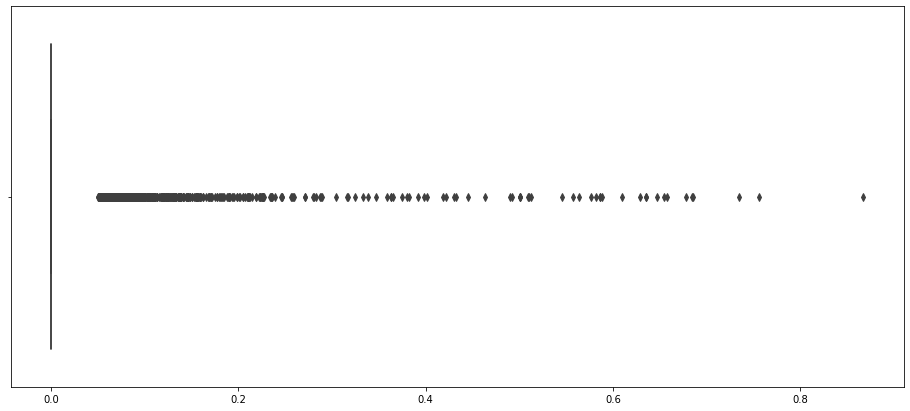

In [33]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=KNNscores)

In [ ]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=RP3Betascores)

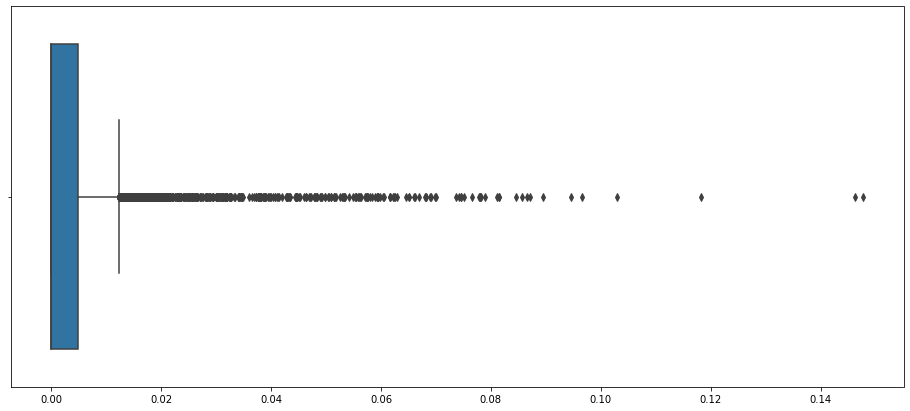

In [34]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=RP3Betascores)

In [63]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

alpha = 0.5
new_similarity = alpha  * recommenderRP3Beta.W_sparse + (1 - alpha) * recommenderItemAsymmetric.W_sparse

recommender_obj = ItemKNNCustomSimilarityRecommender(URM_train)

recommender_obj.fit(new_similarity)
result_df, _ = evaluator_validation.evaluateRecommender(recommender_obj)
result_df

EvaluatorHoldout: Processed 37909 (100.0%) in 25.04 sec. Users per second: 1514


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.031605,0.078252,0.077111,0.01416,0.035052,0.111154,0.072474,0.044834,0.245694,0.125168,...,0.910639,0.223738,0.910639,0.026376,9.304302,0.996059,0.051954,0.68958,3.304542,0.266097


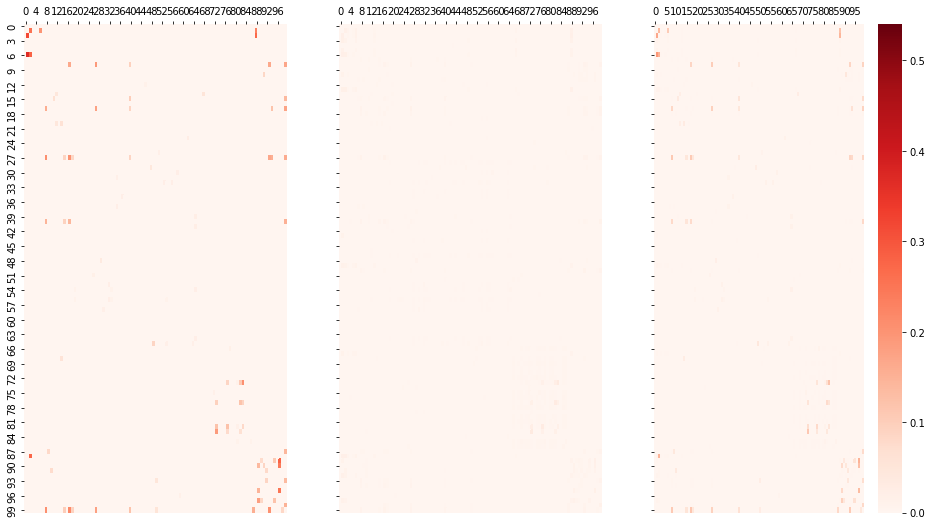

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


ItemKNN_sim = recommenderItemAsymmetric.W_sparse
RP3_sim = recommenderRP3Beta.W_sparse
ItemKNNRP3_sim = recommender_obj.W_sparse

ItemKNN_sim_max = ItemKNN_sim.max()
RP3_sim_max = RP3_sim.max()
ItemKNNRP3_sim_max = ItemKNNRP3_sim.max()
vmax = np.max([ItemKNN_sim_max, RP3_sim_max, ItemKNNRP3_sim_max])

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.heatmap(ItemKNN_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
sns.heatmap(RP3_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds")
sns.heatmap(ItemKNNRP3_sim[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3, cmap="Reds")
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


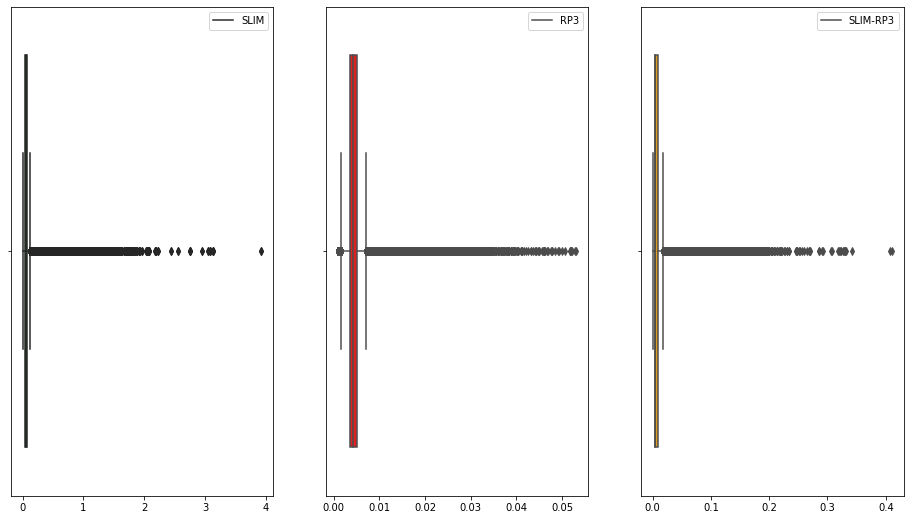

In [ ]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.boxplot(x=SLIM_sim.data, orient="v", ax=ax1, color="green")
sns.boxplot(x=RP3_sim.data, orient="v", ax=ax2, color="red")
sns.boxplot(x=SLIMRP3_sim.data, orient="v", ax=ax3, color="orange")
ax1.legend(["SLIM"])
ax2.legend(["RP3"])
ax3.legend(["SLIM-RP3"])

In [76]:
# model3 - EASE_R
# topK=None, "normalize_matrix"=False, "l2_norm"=196.614729453597
recommenderEASE = EASE_R_Recommender(URM_train)
recommenderEASE.fit(topK=None, normalize_matrix=False, l2_norm=196.614729453597) #hyperparameters gotten from tuning
#recommenderEASE.load_model(output_folder_path, file_name="EASE_R_Recommender_best_model.zip")

result_df, _ = evaluator_validation.evaluateRecommender(recommenderEASE)
result_df

EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 8.46 min
EvaluatorHoldout: Processed 38124 (100.0%) in 37.83 sec. Users per second: 1008


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.033882,0.085135,0.083896,0.015326,0.038677,0.119688,0.076481,0.048269,0.261095,0.134965,...,0.915804,0.239112,0.915804,0.013795,8.400568,0.991831,0.027145,0.622486,4.63985,0.249655


In [195]:
r = data_loader.load_data("EASE_R_Recommender_metadata.zip")

#search_metadata_P3alpha.keys()
result_on_validation_df = r["result_on_validation_best"]
result_on_validation_df

{'PRECISION': 0.033076578121290265,
 'PRECISION_RECALL_MIN_DEN': 0.08335221731908501,
 'RECALL': 0.08211399834991089,
 'MAP': 0.014685930216345419,
 'MAP_MIN_DEN': 0.0369832027900471,
 'MRR': 0.11561622925744983,
 'NDCG': 0.07739261536195156,
 'F1': 0.047157504797302026,
 'HIT_RATE': 0.2579862301828062,
 'ARHR_ALL_HITS': 0.12997133486331325,
 'NOVELTY': 0.004125241020629105,
 'AVERAGE_POPULARITY': 0.2443795242643026,
 'DIVERSITY_MEAN_INTER_LIST': 0.904183152368573,
 'DIVERSITY_HERFINDAHL': 0.9904159300957236,
 'COVERAGE_ITEM': 0.10845880768759947,
 'COVERAGE_ITEM_HIT': 0.040804668054025384,
 'ITEMS_IN_GT': 0.9563798098502468,
 'COVERAGE_USER': 0.9106392178529391,
 'COVERAGE_USER_HIT': 0.23493237887049892,
 'USERS_IN_GT': 0.9106392178529391,
 'DIVERSITY_GINI': 0.012086302657998186,
 'SHANNON_ENTROPY': 8.212536590086309,
 'RATIO_DIVERSITY_HERFINDAHL': 0.9907432628248009,
 'RATIO_DIVERSITY_GINI': 0.023807166538662897,
 'RATIO_SHANNON_ENTROPY': 0.608665198706193,
 'RATIO_AVERAGE_POPULARITY

### Hyperparameter tuning 

First tune the model with RP3Beta and ItemKNN, then the resulting W_sparse is tuned with the remaining EASE model

Havin more than 2 models to hybridize, start making the hybrid of the first 2, then hybridize again the other model with the 2-models tuned. 

In [77]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

In [154]:
hyperparameters_range_dictionary = {
    "topK": Integer(5, 1000),
    "alpha": Real(low = 0.1, high = 0.9, prior = 'uniform')
}


recommender_class = ItemKNNSimilarityHybridRecommender

recommender_class.RECOMMENDER_NAME = "ItemKNNHybrid_RP3_ItemKNNAsymmetric_URM_tuned"

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, recommenderItemAsymmetric.W_sparse, recommenderRP3Beta.W_sparse], # For a hybrid model put [URM_train, W_sparse1, W_sparse2]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation, recommenderItemAsymmetric.W_sparse, recommenderRP3Beta.W_sparse], # For a hybrid model put [URM_train_validation, W_sparse1, W_sparse2]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = 70,
                       n_random_starts = n_random_starts,
                       save_model = "best",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                      )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 811, 'alpha': 0.3349649156360517}
EvaluatorHoldout: Processed 37997 (100.0%) in 27.37 sec. Users per second: 1388
SearchBayesianSkopt: New best config found. Config 0: {'topK': 811, 'alpha': 0.3349649156360517} - results: PRECISION: 0.0310788, PRECISION_RECALL_MIN_DEN: 0.0779601, RECALL: 0.0768594, MAP: 0.0140951, MAP_MIN_DEN: 0.0351368, MRR: 0.1108752, NDCG: 0.0682428, F1: 0.0442604, HIT_RATE: 0.2431508, ARHR_ALL_HITS: 0.1247230, NOVELTY: 0.0042510, AVERAGE_POPULARITY: 0.2279452, DIVERSITY_MEAN_INTER_LIST: 0.9065031, DIVERSITY_HERFINDAHL: 0.9906479, COVERAGE_ITEM: 0.4475456, COVERAGE_ITEM_HIT: 0.0416208, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2219366, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0280659, SHANNON_ENTROPY: 8.5556777, RATIO_DIVERSITY_HERFINDAHL: 0.9909739, RATIO_DIVERSITY_GINI: 0.0552487, RATIO_SHANNON_ENTROPY: 0.6340143, RATIO_AVERAGE_

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 35.2568
Function value obtained: -0.0346
Current minimum: -0.0358
Iteration No: 6 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 415, 'alpha': 0.6076559295073972}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.64 sec. Users per second: 1426
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'topK': 415, 'alpha': 0.6076559295073972} - results: PRECISION: 0.0306840, PRECISION_RECALL_MIN_DEN: 0.0768785, RECALL: 0.0757896, MAP: 0.0138974, MAP_MIN_DEN: 0.0346639, MRR: 0.1094855, NDCG: 0.0672853, F1: 0.0436827, HIT_RATE: 0.2403611, ARHR_ALL_HITS: 0.1230620, NOVELTY: 0.0042600, AVERAGE_POPULARITY: 0.2269983, DIVERSITY_MEAN_INTER_LIST: 0.9052962, DIVERSITY_HERFINDAHL: 0.9905272, COVERAGE_ITEM: 0.4479945, COVERAGE_ITEM_HIT: 0.0417840, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2193903, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0283960, SHANNON_ENTROPY

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 22.8706
Function value obtained: -0.0344
Current minimum: -0.0358
Iteration No: 13 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 523, 'alpha': 0.5409246846915746}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.45 sec. Users per second: 1436
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'topK': 523, 'alpha': 0.5409246846915746} - results: PRECISION: 0.0307735, PRECISION_RECALL_MIN_DEN: 0.0771196, RECALL: 0.0760280, MAP: 0.0139430, MAP_MIN_DEN: 0.0347667, MRR: 0.1098955, NDCG: 0.0675209, F1: 0.0438130, HIT_RATE: 0.2413085, ARHR_ALL_HITS: 0.1234939, NOVELTY: 0.0042580, AVERAGE_POPULARITY: 0.2272330, DIVERSITY_MEAN_INTER_LIST: 0.9054974, DIVERSITY_HERFINDAHL: 0.9905474, COVERAGE_ITEM: 0.4478312, COVERAGE_ITEM_HIT: 0.0417840, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2202551, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0283239, SHANNON_ENTR

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 35.4047
Function value obtained: -0.0344
Current minimum: -0.0358
Iteration No: 20 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 750, 'alpha': 0.6700086332804691}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.52 sec. Users per second: 1433
SearchBayesianSkopt: Config 19 is suboptimal. Config: {'topK': 750, 'alpha': 0.6700086332804691} - results: PRECISION: 0.0305814, PRECISION_RECALL_MIN_DEN: 0.0766875, RECALL: 0.0756043, MAP: 0.0138584, MAP_MIN_DEN: 0.0345609, MRR: 0.1092091, NDCG: 0.0670918, F1: 0.0435479, HIT_RATE: 0.2398347, ARHR_ALL_HITS: 0.1227389, NOVELTY: 0.0042614, AVERAGE_POPULARITY: 0.2268051, DIVERSITY_MEAN_INTER_LIST: 0.9051741, DIVERSITY_HERFINDAHL: 0.9905150, COVERAGE_ITEM: 0.4476680, COVERAGE_ITEM_HIT: 0.0417432, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2189099, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0284432, SHANNON_ENTR

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 21.3757
Function value obtained: -0.0315
Current minimum: -0.0359
Iteration No: 26 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 990, 'alpha': 0.18684533146583537}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.71 sec. Users per second: 1423
SearchBayesianSkopt: Config 25 is suboptimal. Config: {'topK': 990, 'alpha': 0.18684533146583537} - results: PRECISION: 0.0314209, PRECISION_RECALL_MIN_DEN: 0.0786902, RECALL: 0.0775748, MAP: 0.0142380, MAP_MIN_DEN: 0.0354616, MRR: 0.1117499, NDCG: 0.0689377, F1: 0.0447260, HIT_RATE: 0.2450193, ARHR_ALL_HITS: 0.1258516, NOVELTY: 0.0042447, AVERAGE_POPULARITY: 0.2286056, DIVERSITY_MEAN_INTER_LIST: 0.9079368, DIVERSITY_HERFINDAHL: 0.9907913, COVERAGE_ITEM: 0.4585629, COVERAGE_ITEM_HIT: 0.0408863, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2236422, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0285258

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 36.1747
Function value obtained: -0.0359
Current minimum: -0.0359
Iteration No: 33 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 634, 'alpha': 0.1}
EvaluatorHoldout: Processed 37997 (100.0%) in 27.01 sec. Users per second: 1407
SearchBayesianSkopt: Config 32 is suboptimal. Config: {'topK': 634, 'alpha': 0.1} - results: PRECISION: 0.0318630, PRECISION_RECALL_MIN_DEN: 0.0801979, RECALL: 0.0790732, MAP: 0.0143657, MAP_MIN_DEN: 0.0358734, MRR: 0.1126606, NDCG: 0.0698436, F1: 0.0454227, HIT_RATE: 0.2485196, ARHR_ALL_HITS: 0.1269369, NOVELTY: 0.0042467, AVERAGE_POPULARITY: 0.2281083, DIVERSITY_MEAN_INTER_LIST: 0.9101493, DIVERSITY_HERFINDAHL: 0.9910125, COVERAGE_ITEM: 0.4745991, COVERAGE_ITEM_HIT: 0.0406414, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2268371, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0300151, SHANNON_ENTROPY: 8.5895534, RA

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 36.1101
Function value obtained: -0.0354
Current minimum: -0.0359
Iteration No: 40 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 988, 'alpha': 0.5071522153720662}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.65 sec. Users per second: 1426
SearchBayesianSkopt: Config 39 is suboptimal. Config: {'topK': 988, 'alpha': 0.5071522153720662} - results: PRECISION: 0.0307945, PRECISION_RECALL_MIN_DEN: 0.0771418, RECALL: 0.0760534, MAP: 0.0139574, MAP_MIN_DEN: 0.0348150, MRR: 0.1100128, NDCG: 0.0675909, F1: 0.0438385, HIT_RATE: 0.2414927, ARHR_ALL_HITS: 0.1236227, NOVELTY: 0.0042571, AVERAGE_POPULARITY: 0.2272899, DIVERSITY_MEAN_INTER_LIST: 0.9056558, DIVERSITY_HERFINDAHL: 0.9905632, COVERAGE_ITEM: 0.4474640, COVERAGE_ITEM_HIT: 0.0417840, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2204233, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0282758, 

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 36.1999
Function value obtained: -0.0348
Current minimum: -0.0359
Iteration No: 47 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 995, 'alpha': 0.5386333514740778}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.53 sec. Users per second: 1432
SearchBayesianSkopt: Config 46 is suboptimal. Config: {'topK': 995, 'alpha': 0.5386333514740778} - results: PRECISION: 0.0307787, PRECISION_RECALL_MIN_DEN: 0.0771327, RECALL: 0.0760412, MAP: 0.0139446, MAP_MIN_DEN: 0.0347686, MRR: 0.1099060, NDCG: 0.0675297, F1: 0.0438205, HIT_RATE: 0.2413612, ARHR_ALL_HITS: 0.1235070, NOVELTY: 0.0042580, AVERAGE_POPULARITY: 0.2272307, DIVERSITY_MEAN_INTER_LIST: 0.9055128, DIVERSITY_HERFINDAHL: 0.9905489, COVERAGE_ITEM: 0.4479536, COVERAGE_ITEM_HIT: 0.0418248, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2203032, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0283283, 

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 34.4215
Function value obtained: -0.0359
Current minimum: -0.0359
Iteration No: 54 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 199, 'alpha': 0.46623763864474044}
EvaluatorHoldout: Processed 37997 (100.0%) in 24.79 sec. Users per second: 1532
SearchBayesianSkopt: Config 53 is suboptimal. Config: {'topK': 199, 'alpha': 0.46623763864474044} - results: PRECISION: 0.0309445, PRECISION_RECALL_MIN_DEN: 0.0773100, RECALL: 0.0762106, MAP: 0.0140306, MAP_MIN_DEN: 0.0348941, MRR: 0.1103101, NDCG: 0.0677471, F1: 0.0440166, HIT_RATE: 0.2417296, ARHR_ALL_HITS: 0.1241190, NOVELTY: 0.0042834, AVERAGE_POPULARITY: 0.2175370, DIVERSITY_MEAN_INTER_LIST: 0.9154975, DIVERSITY_HERFINDAHL: 0.9915473, COVERAGE_ITEM: 0.4365691, COVERAGE_ITEM_HIT: 0.0430489, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2206395, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0284334

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 36.2038
Function value obtained: -0.0343
Current minimum: -0.0359
Iteration No: 61 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 535, 'alpha': 0.19397659224433764}
EvaluatorHoldout: Processed 37997 (100.0%) in 26.65 sec. Users per second: 1426
SearchBayesianSkopt: Config 60 is suboptimal. Config: {'topK': 535, 'alpha': 0.19397659224433764} - results: PRECISION: 0.0313867, PRECISION_RECALL_MIN_DEN: 0.0786539, RECALL: 0.0775429, MAP: 0.0142268, MAP_MIN_DEN: 0.0354322, MRR: 0.1116910, NDCG: 0.0688818, F1: 0.0446860, HIT_RATE: 0.2448351, ARHR_ALL_HITS: 0.1257676, NOVELTY: 0.0042449, AVERAGE_POPULARITY: 0.2285838, DIVERSITY_MEAN_INTER_LIST: 0.9078476, DIVERSITY_HERFINDAHL: 0.9907824, COVERAGE_ITEM: 0.4571347, COVERAGE_ITEM_HIT: 0.0408455, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2234740, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0284432

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 36.1320
Function value obtained: -0.0344
Current minimum: -0.0359
Iteration No: 68 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 588, 'alpha': 0.1}
EvaluatorHoldout: Processed 37997 (100.0%) in 27.14 sec. Users per second: 1400
SearchBayesianSkopt: Config 67 is suboptimal. Config: {'topK': 588, 'alpha': 0.1} - results: PRECISION: 0.0318630, PRECISION_RECALL_MIN_DEN: 0.0801979, RECALL: 0.0790732, MAP: 0.0143657, MAP_MIN_DEN: 0.0358734, MRR: 0.1126606, NDCG: 0.0698436, F1: 0.0454227, HIT_RATE: 0.2485196, ARHR_ALL_HITS: 0.1269369, NOVELTY: 0.0042467, AVERAGE_POPULARITY: 0.2281083, DIVERSITY_MEAN_INTER_LIST: 0.9101493, DIVERSITY_HERFINDAHL: 0.9910125, COVERAGE_ITEM: 0.4745991, COVERAGE_ITEM_HIT: 0.0406414, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2268371, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0300151, SHANNON_ENTROPY: 8.5895534, RA

In [229]:
# hyperparameter_tuning_experiments/ItemKNNSimilarityHybridRecommender_metadata.zip
data_loader = DataIO(folder_path = output_folder_path)
search_metadata_HybridItemKNN = data_loader.load_data("ItemKNNHybrid_RP3_ItemKNNAsymmetric_metadata.zip")

#search_metadata_HybridItemKNN.keys()
result_on_validation_df = search_metadata_HybridItemKNN["result_on_validation_best"]
result_on_validation_df

{'PRECISION': 0.032513120763773495,
 'PRECISION_RECALL_MIN_DEN': 0.08165769134002328,
 'RECALL': 0.08041757938211999,
 'MAP': 0.014655920345650837,
 'MAP_MIN_DEN': 0.0365435710363924,
 'MRR': 0.1145478783859989,
 'NDCG': 0.07529633413102312,
 'F1': 0.04630497228129131,
 'HIT_RATE': 0.2522087717910172,
 'ARHR_ALL_HITS': 0.1292083460490772,
 'NOVELTY': 0.004342702017144887,
 'AVERAGE_POPULARITY': 0.1927994419637844,
 'DIVERSITY_MEAN_INTER_LIST': 0.9406906381541531,
 'DIVERSITY_HERFINDAHL': 0.9940665828948833,
 'COVERAGE_ITEM': 0.25074468519198595,
 'COVERAGE_ITEM_HIT': 0.04921042967315461,
 'ITEMS_IN_GT': 0.9535642877545191,
 'COVERAGE_USER': 0.9108313915779865,
 'COVERAGE_USER_HIT': 0.22971966657858706,
 'USERS_IN_GT': 0.9108313915779865,
 'DIVERSITY_GINI': 0.02344571205903212,
 'SHANNON_ENTROPY': 8.995495250609842,
 'RATIO_DIVERSITY_HERFINDAHL': 0.9943955909799184,
 'RATIO_DIVERSITY_GINI': 0.04617283497802571,
 'RATIO_SHANNON_ENTROPY': 0.6667078091592964,
 'RATIO_AVERAGE_POPULARITY': 3

In [230]:
best_hpItem = search_metadata_HybridItemKNN["hyperparameters_best"]
best_hpItem

{'topK': 185, 'alpha': 0.10371160354529946}

In [75]:
recommenderRP3Beta_ItemKNNAsymm = ItemKNNSimilarityHybridRecommender(URM_train, recommenderItemAsymmetric.W_sparse, recommenderRP3Beta.W_sparse)
recommenderRP3Beta_ItemKNNAsymm.fit(topK=185, alpha=0.10371160354529946) #hyperparameters gotten from tuning

result_df, _ = evaluator_validation.evaluateRecommender(recommenderRP3Beta_ItemKNNAsymm)
result_df

EvaluatorHoldout: Processed 38124 (100.0%) in 27.37 sec. Users per second: 1393


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.032628,0.081537,0.080298,0.014884,0.037214,0.115829,0.07329,0.046401,0.2516,0.130866,...,0.915804,0.230416,0.915804,0.02659,9.141339,0.994871,0.052323,0.677378,3.705375,0.263054


### We have to normalize scores of Hybrid_ItemKNN_RP3 with and EASE before to merge them

Inspecting the scores of the hybrid model (based on KNN) and EASE_R, we can see that they have totally different meaning

In [160]:
user_id = 0

In [78]:
hybridKNN_Rp3Betascores = recommenderRP3Beta_ItemKNNAsymm._compute_item_score(user_id)
EASEscores = recommenderEASE._compute_item_score(user_id)

In [162]:
np.percentile(hybridKNN_Rp3Betascores, [0, 25, 50, 75, 100])

array([0.        , 0.        , 0.        , 0.00051857, 0.03944763])

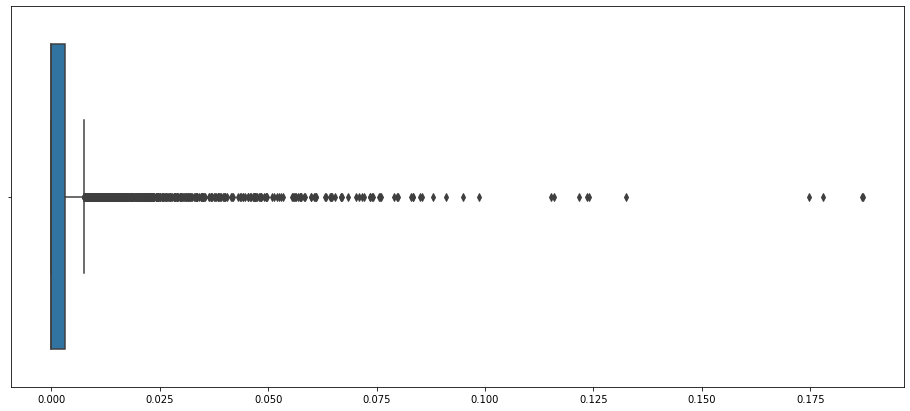

In [79]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=hybridKNN_Rp3Betascores)

In [40]:
np.percentile(EASEscores, [0, 25, 50, 75, 100])

array([-0.02385749, -0.00074884,  0.0002439 ,  0.00151905,  0.23419231])

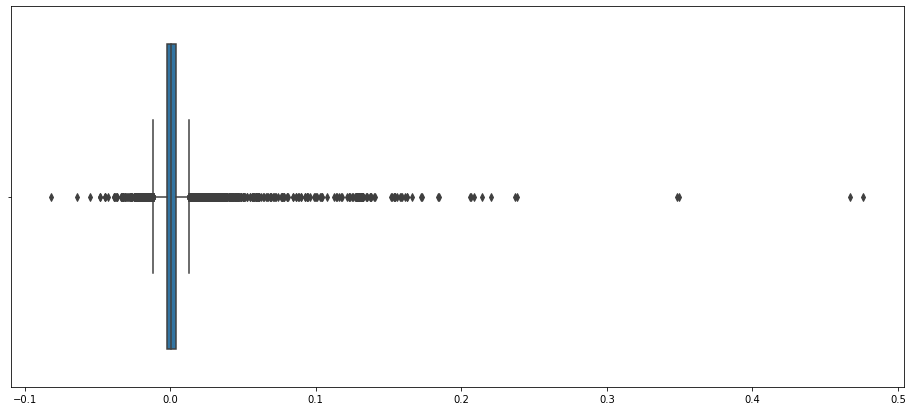

In [80]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=EASEscores)

In [81]:
from Recommenders.BaseRecommender import BaseRecommender

class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.
    """
    
    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights

    def save_model(self, folder_path, file_name = None):

        if file_name is None:
            file_name = self.RECOMMENDER_NAME

        self._print("Saving model in file '{}'".format(folder_path + file_name))

        data_dict_to_save = {"W_sparse": self.W_sparse}

        dataIO = DataIO(folder_path=folder_path)
        dataIO.save_data(file_name=file_name, data_dict_to_save = data_dict_to_save)

        self._print("Saving complete")

Now ensemble the last model with the two already ensembled

In [170]:
hyperparameters_range_dictionary = {
    "norm": Categorical([2]),
    "alpha": Real(low = 0.1, high = 0.9, prior = 'uniform')
}


recommender_class = DifferentLossScoresHybridRecommender

recommender_class.RECOMMENDER_NAME = "RP3ItemKNNAsymEASE_normalized_URMtuned"

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, recommenderRP3Beta_ItemKNNAsymm, recommenderEASE], # For a model with different loss functions put [URM_train, rec1, rec2]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation, recommenderRP3Beta_ItemKNNAsymm, recommenderEASE], # For a hybrid model put [URM_train_validation, W_sparse1, W_sparse2]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = n_random_starts,
                       save_model = "best",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                      )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.6790779272316405}
EvaluatorHoldout: Processed 37997 (100.0%) in 5.02 min. Users per second: 126
SearchBayesianSkopt: New best config found. Config 0: {'norm': 2, 'alpha': 0.6790779272316405} - results: PRECISION: 0.0310577, PRECISION_RECALL_MIN_DEN: 0.0777278, RECALL: 0.0765960, MAP: 0.0129666, MAP_MIN_DEN: 0.0312720, MRR: 0.1008066, NDCG: 0.0641069, F1: 0.0441954, HIT_RATE: 0.2431245, ARHR_ALL_HITS: 0.1140934, NOVELTY: 0.0040952, AVERAGE_POPULARITY: 0.2654166, DIVERSITY_MEAN_INTER_LIST: 0.8729726, DIVERSITY_HERFINDAHL: 0.9872950, COVERAGE_ITEM: 0.3578569, COVERAGE_ITEM_HIT: 0.0355817, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2219126, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0180919, SHANNON_ENTROPY: 7.9573082, RATIO_DIVERSITY_HERFINDAHL: 0.9876198, RATIO_DIVERSITY_GINI: 0.0356145, RATIO_SHANNON_ENTROPY: 0.5896724, RATIO_AVERAGE_POPULA

Traceback (most recent call last):
  File "C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\HyperparameterTuning\SearchAbstractClass.py", line 534, in _objective_function
    recommender_instance.save_model(self.output_folder_path, file_name =self.output_file_name_root + "_best_model")
  File "<ipython-input-166-3e2ac9ded4fb>", line 53, in save_model
    data_dict_to_save = {"W_sparse": self.W_sparse}
AttributeError: 'DifferentLossScoresHybridRecommender' object has no attribute 'W_sparse'


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 601.7538
Function value obtained: 65504.0000
Current minimum: 65504.0000
Iteration No: 2 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.5482186121541915}
EvaluatorHoldout: Processed 37997 (100.0%) in 5.06 min. Users per second: 125
SearchBayesianSkopt: Config 1 is suboptimal. Config: {'norm': 2, 'alpha': 0.5482186121541915} - results: PRECISION: 0.0303471, PRECISION_RECALL_MIN_DEN: 0.0756246, RECALL: 0.0745025, MAP: 0.0123651, MAP_MIN_DEN: 0.0295037, MRR: 0.0957045, NDCG: 0.0614627, F1: 0.0431272, HIT_RATE: 0.2378609, ARHR_ALL_HITS: 0.1085846, NOVELTY: 0.0040369, AVERAGE_POPULARITY: 0.2796757, DIVERSITY_MEAN_INTER_LIST: 0.8570959, DIVERSITY_HERFINDAHL: 0.9857073, COVERAGE_ITEM: 0.3033011, COVERAGE_ITEM_HIT: 0.0334190, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2171083, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0140972, SHANNON_ENTROP

Traceback (most recent call last):
  File "C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\HyperparameterTuning\SearchAbstractClass.py", line 534, in _objective_function
    recommender_instance.save_model(self.output_folder_path, file_name =self.output_file_name_root + "_best_model")
  File "<ipython-input-166-3e2ac9ded4fb>", line 53, in save_model
    data_dict_to_save = {"W_sparse": self.W_sparse}
AttributeError: 'DifferentLossScoresHybridRecommender' object has no attribute 'W_sparse'


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 596.8370
Function value obtained: 65504.0000
Current minimum: -0.0295
Iteration No: 6 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.12701599101973066}
EvaluatorHoldout: Processed 37997 (100.0%) in 4.91 min. Users per second: 129
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'norm': 2, 'alpha': 0.12701599101973066} - results: PRECISION: 0.0274337, PRECISION_RECALL_MIN_DEN: 0.0672830, RECALL: 0.0662010, MAP: 0.0104699, MAP_MIN_DEN: 0.0243795, MRR: 0.0808593, NDCG: 0.0528231, F1: 0.0387920, HIT_RATE: 0.2163066, ARHR_ALL_HITS: 0.0918465, NOVELTY: 0.0038707, AVERAGE_POPULARITY: 0.3230171, DIVERSITY_MEAN_INTER_LIST: 0.8033351, DIVERSITY_HERFINDAHL: 0.9803314, COVERAGE_ITEM: 0.1151508, COVERAGE_ITEM_HIT: 0.0246868, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.1974345, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0054887, SHANNON_ENTROPY

EvaluatorHoldout: Processed 38753 (100.0%) in 5.05 min. Users per second: 128
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'norm': 2, 'alpha': 0.7595674721456452} - results:
CUTOFF: 10 - PRECISION: 0.0341935, PRECISION_RECALL_MIN_DEN: 0.0787523, RECALL: 0.0772027, MAP: 0.0145452, MAP_MIN_DEN: 0.0327186, MRR: 0.1123064, NDCG: 0.0679051, F1: 0.0473953, HIT_RATE: 0.2629216, ARHR_ALL_HITS: 0.1275053, NOVELTY: 0.0041367, AVERAGE_POPULARITY: 0.2556904, DIVERSITY_MEAN_INTER_LIST: 0.8834832, DIVERSITY_HERFINDAHL: 0.9883460, COVERAGE_ITEM: 0.4083323, COVERAGE_ITEM_HIT: 0.0386828, ITEMS_IN_GT: 0.9672747, COVERAGE_USER: 0.9309135, COVERAGE_USER_HIT: 0.2447573, USERS_IN_GT: 0.9309135, DIVERSITY_GINI: 0.0218791, SHANNON_ENTROPY: 8.1403939, RATIO_DIVERSITY_HERFINDAHL: 0.9886712, RATIO_DIVERSITY_GINI: 0.0430699, RATIO_SHANNON_ENTROPY: 0.6032399, RATIO_AVERAGE_POPULARITY: 5.0430357, RATIO_NOVELTY: 0.2483546, 


SearchBayesianSkopt: Saving model in hyperparameter_tuning_experimen

Traceback (most recent call last):
  File "C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\HyperparameterTuning\SearchAbstractClass.py", line 534, in _objective_function
    recommender_instance.save_model(self.output_folder_path, file_name =self.output_file_name_root + "_best_model")
  File "<ipython-input-166-3e2ac9ded4fb>", line 53, in save_model
    data_dict_to_save = {"W_sparse": self.W_sparse}
AttributeError: 'DifferentLossScoresHybridRecommender' object has no attribute 'W_sparse'


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 599.3363
Function value obtained: 65504.0000
Current minimum: -0.0295
Iteration No: 13 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.362276469302775}
EvaluatorHoldout: Processed 37997 (100.0%) in 5.03 min. Users per second: 126
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'norm': 2, 'alpha': 0.362276469302775} - results: PRECISION: 0.0292128, PRECISION_RECALL_MIN_DEN: 0.0722906, RECALL: 0.0711829, MAP: 0.0115211, MAP_MIN_DEN: 0.0271558, MRR: 0.0887983, NDCG: 0.0576927, F1: 0.0414251, HIT_RATE: 0.2292813, ARHR_ALL_HITS: 0.1009818, NOVELTY: 0.0039624, AVERAGE_POPULARITY: 0.2985386, DIVERSITY_MEAN_INTER_LIST: 0.8347746, DIVERSITY_HERFINDAHL: 0.9834753, COVERAGE_ITEM: 0.2303424, COVERAGE_ITEM_HIT: 0.0299098, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2092772, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0097837, SHANNON_ENTROPY:

Traceback (most recent call last):
  File "C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\HyperparameterTuning\SearchAbstractClass.py", line 534, in _objective_function
    recommender_instance.save_model(self.output_folder_path, file_name =self.output_file_name_root + "_best_model")
  File "<ipython-input-166-3e2ac9ded4fb>", line 53, in save_model
    data_dict_to_save = {"W_sparse": self.W_sparse}
AttributeError: 'DifferentLossScoresHybridRecommender' object has no attribute 'W_sparse'


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 606.3511
Function value obtained: 65504.0000
Current minimum: -0.0323
Iteration No: 16 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.28926118932292877}
EvaluatorHoldout: Processed 37997 (100.0%) in 5.10 min. Users per second: 124
SearchBayesianSkopt: Config 15 is suboptimal. Config: {'norm': 2, 'alpha': 0.28926118932292877} - results: PRECISION: 0.0287075, PRECISION_RECALL_MIN_DEN: 0.0708390, RECALL: 0.0697337, MAP: 0.0111903, MAP_MIN_DEN: 0.0262777, MRR: 0.0862488, NDCG: 0.0561851, F1: 0.0406716, HIT_RATE: 0.2254389, ARHR_ALL_HITS: 0.0980723, NOVELTY: 0.0039344, AVERAGE_POPULARITY: 0.3058145, DIVERSITY_MEAN_INTER_LIST: 0.8256987, DIVERSITY_HERFINDAHL: 0.9825677, COVERAGE_ITEM: 0.1982699, COVERAGE_ITEM_HIT: 0.0284409, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2057700, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0083215, SHANNON_ENTR

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 302.3124
Function value obtained: -0.0324
Current minimum: -0.0324
Iteration No: 23 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.7675274723863654}
EvaluatorHoldout: Processed 37997 (100.0%) in 4.98 min. Users per second: 127
SearchBayesianSkopt: Config 22 is suboptimal. Config: {'norm': 2, 'alpha': 0.7675274723863654} - results: PRECISION: 0.0313604, PRECISION_RECALL_MIN_DEN: 0.0786084, RECALL: 0.0774781, MAP: 0.0133682, MAP_MIN_DEN: 0.0324725, MRR: 0.1041691, NDCG: 0.0657144, F1: 0.0446486, HIT_RATE: 0.2455457, ARHR_ALL_HITS: 0.1177670, NOVELTY: 0.0041372, AVERAGE_POPULARITY: 0.2551552, DIVERSITY_MEAN_INTER_LIST: 0.8839261, DIVERSITY_HERFINDAHL: 0.9883903, COVERAGE_ITEM: 0.3954380, COVERAGE_ITEM_HIT: 0.0370098, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2241226, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0212866, SHANNON_ENTROPY:

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 299.3899
Function value obtained: -0.0289
Current minimum: -0.0326
Iteration No: 30 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.5680698844731531}
EvaluatorHoldout: Processed 37997 (100.0%) in 4.99 min. Users per second: 127
SearchBayesianSkopt: Config 29 is suboptimal. Config: {'norm': 2, 'alpha': 0.5680698844731531} - results: PRECISION: 0.0304261, PRECISION_RECALL_MIN_DEN: 0.0758672, RECALL: 0.0747436, MAP: 0.0124350, MAP_MIN_DEN: 0.0297298, MRR: 0.0963031, NDCG: 0.0617852, F1: 0.0432474, HIT_RATE: 0.2384662, ARHR_ALL_HITS: 0.1092282, NOVELTY: 0.0040454, AVERAGE_POPULARITY: 0.2775245, DIVERSITY_MEAN_INTER_LIST: 0.8595563, DIVERSITY_HERFINDAHL: 0.9859534, COVERAGE_ITEM: 0.3110132, COVERAGE_ITEM_HIT: 0.0337863, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2176608, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0146321, SHANN

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 299.2071
Function value obtained: -0.0260
Current minimum: -0.0326
Iteration No: 37 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.3411586329545973}
EvaluatorHoldout: Processed 37997 (100.0%) in 5.00 min. Users per second: 127
SearchBayesianSkopt: Config 36 is suboptimal. Config: {'norm': 2, 'alpha': 0.3411586329545973} - results: PRECISION: 0.0290602, PRECISION_RECALL_MIN_DEN: 0.0718758, RECALL: 0.0707700, MAP: 0.0114337, MAP_MIN_DEN: 0.0269142, MRR: 0.0881011, NDCG: 0.0572792, F1: 0.0412018, HIT_RATE: 0.2281759, ARHR_ALL_HITS: 0.1001979, NOVELTY: 0.0039542, AVERAGE_POPULARITY: 0.3006577, DIVERSITY_MEAN_INTER_LIST: 0.8321703, DIVERSITY_HERFINDAHL: 0.9832148, COVERAGE_ITEM: 0.2211205, COVERAGE_ITEM_HIT: 0.0295426, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2082683, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0093390, SHANN

Traceback (most recent call last):
  File "C:\Users\ste_9\OneDrive - Politecnico di Milano\PoliMi\SECONDO ANNO\I semestre\Recommender Systems\RecSys_Course_AT_PoliMi\HyperparameterTuning\SearchAbstractClass.py", line 534, in _objective_function
    recommender_instance.save_model(self.output_folder_path, file_name =self.output_file_name_root + "_best_model")
  File "<ipython-input-166-3e2ac9ded4fb>", line 53, in save_model
    data_dict_to_save = {"W_sparse": self.W_sparse}
AttributeError: 'DifferentLossScoresHybridRecommender' object has no attribute 'W_sparse'


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 605.0687
Function value obtained: 65504.0000
Current minimum: -0.0326
Iteration No: 41 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.7561844267486654}
EvaluatorHoldout: Processed 37997 (100.0%) in 4.98 min. Users per second: 127
SearchBayesianSkopt: Config 40 is suboptimal. Config: {'norm': 2, 'alpha': 0.7561844267486654} - results: PRECISION: 0.0312893, PRECISION_RECALL_MIN_DEN: 0.0783813, RECALL: 0.0772497, MAP: 0.0133015, MAP_MIN_DEN: 0.0322932, MRR: 0.1036106, NDCG: 0.0654358, F1: 0.0445386, HIT_RATE: 0.2449930, ARHR_ALL_HITS: 0.1171611, NOVELTY: 0.0041316, AVERAGE_POPULARITY: 0.2565118, DIVERSITY_MEAN_INTER_LIST: 0.8825046, DIVERSITY_HERFINDAHL: 0.9882481, COVERAGE_ITEM: 0.3902966, COVERAGE_ITEM_HIT: 0.0369282, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2236182, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0208480, SH

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 299.9375
Function value obtained: -0.0324
Current minimum: -0.0326
Iteration No: 48 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.7619245327876463}
EvaluatorHoldout: Processed 37997 (100.0%) in 4.99 min. Users per second: 127
SearchBayesianSkopt: Config 47 is suboptimal. Config: {'norm': 2, 'alpha': 0.7619245327876463} - results: PRECISION: 0.0313235, PRECISION_RECALL_MIN_DEN: 0.0784905, RECALL: 0.0773617, MAP: 0.0133394, MAP_MIN_DEN: 0.0323888, MRR: 0.1039354, NDCG: 0.0655858, F1: 0.0445919, HIT_RATE: 0.2450983, ARHR_ALL_HITS: 0.1175048, NOVELTY: 0.0041344, AVERAGE_POPULARITY: 0.2558396, DIVERSITY_MEAN_INTER_LIST: 0.8832121, DIVERSITY_HERFINDAHL: 0.9883189, COVERAGE_ITEM: 0.3929490, COVERAGE_ITEM_HIT: 0.0369282, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2237142, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0210704, SHANN

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 299.8934
Function value obtained: -0.0324
Current minimum: -0.0326
Iteration No: 55 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'norm': 2, 'alpha': 0.7561943820828867}
EvaluatorHoldout: Processed 37997 (100.0%) in 4.98 min. Users per second: 127
SearchBayesianSkopt: Config 54 is suboptimal. Config: {'norm': 2, 'alpha': 0.7561943820828867} - results: PRECISION: 0.0312893, PRECISION_RECALL_MIN_DEN: 0.0783813, RECALL: 0.0772497, MAP: 0.0133015, MAP_MIN_DEN: 0.0322932, MRR: 0.1036110, NDCG: 0.0654359, F1: 0.0445386, HIT_RATE: 0.2449930, ARHR_ALL_HITS: 0.1171615, NOVELTY: 0.0041316, AVERAGE_POPULARITY: 0.2565118, DIVERSITY_MEAN_INTER_LIST: 0.8825046, DIVERSITY_HERFINDAHL: 0.9882481, COVERAGE_ITEM: 0.3902966, COVERAGE_ITEM_HIT: 0.0369282, ITEMS_IN_GT: 0.9536867, COVERAGE_USER: 0.9127531, COVERAGE_USER_HIT: 0.2236182, USERS_IN_GT: 0.9127531, DIVERSITY_GINI: 0.0208480, SHANN

c:\users\ste_9\appdata\local\programs\python\python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 

In [216]:
data_loader = DataIO(folder_path = output_folder_path)
search_metadata_HybridItemKNN = data_loader.load_data("RP3_ItemKNNAsym_EASE_scores_normalized_metadata.zip")

#search_metadata_HybridItemKNN.keys()
result_on_validation_df = search_metadata_HybridItemKNN["result_on_validation_best"]
result_on_validation_df

{'PRECISION': 0.03331931779360328,
 'PRECISION_RECALL_MIN_DEN': 0.08457545011364673,
 'RECALL': 0.08327883113053437,
 'MAP': 0.015229816267119672,
 'MAP_MIN_DEN': 0.03841655055495795,
 'MRR': 0.11930312108550398,
 'NDCG': 0.0789268811543731,
 'F1': 0.04759584719862856,
 'HIT_RATE': 0.25837647491656374,
 'ARHR_ALL_HITS': 0.13446487960192524,
 'NOVELTY': 0.0042123485410102595,
 'AVERAGE_POPULARITY': 0.2257071397224644,
 'DIVERSITY_MEAN_INTER_LIST': 0.9211732171124205,
 'DIVERSITY_HERFINDAHL': 0.9921149009475253,
 'COVERAGE_ITEM': 0.16134165748561635,
 'COVERAGE_ITEM_HIT': 0.045782837556616475,
 'ITEMS_IN_GT': 0.9555229118211124,
 'COVERAGE_USER': 0.914098344903793,
 'COVERAGE_USER_HIT': 0.23618150808330732,
 'USERS_IN_GT': 0.914098344903793,
 'DIVERSITY_GINI': 0.016262750855368324,
 'SHANNON_ENTROPY': 8.56084595347877,
 'RATIO_DIVERSITY_HERFINDAHL': 0.9924423811676809,
 'RATIO_DIVERSITY_GINI': 0.032008769785788156,
 'RATIO_SHANNON_ENTROPY': 0.6344473353192216,
 'RATIO_AVERAGE_POPULARITY'

In [53]:
best_hpItem = search_metadata_HybridItemKNN["hyperparameters_best"]
best_hpItem

{'norm': 2.0, 'alpha': 0.39591789889588347}

In [82]:
# {'norm': 2.0, 'alpha': 0.39591789889588347}
recommenderRP3Beta_ItemKNNAsymm_EASE = DifferentLossScoresHybridRecommender(URM_train, recommenderRP3Beta_ItemKNNAsymm, recommenderEASE)
recommenderRP3Beta_ItemKNNAsymm_EASE.fit(norm=2.0, alpha=0.39591789889588347) #hyperparameters gotten from tuning

result_df, _ = evaluator_validation.evaluateRecommender(recommenderRP3Beta_ItemKNNAsymm_EASE)
result_df

EvaluatorHoldout: Processed 26000 (68.2%) in 5.04 min. Users per second: 86
EvaluatorHoldout: Processed 38124 (100.0%) in 7.48 min. Users per second: 85


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.034427,0.086463,0.085181,0.015565,0.039189,0.120729,0.077337,0.049036,0.264505,0.136548,...,0.915804,0.242235,0.915804,0.017453,8.688127,0.993021,0.034344,0.643795,4.321099,0.25437


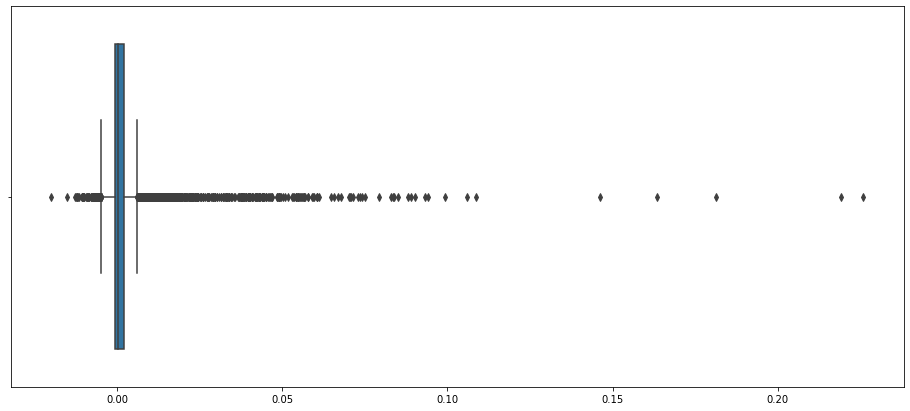

In [83]:
hybrid_scores = recommenderRP3Beta_ItemKNNAsymm_EASE._compute_item_score(0, items_to_compute=None)
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=hybrid_scores)

# Submission

In [44]:
users_to_recommend = users_to_recommend.user_id.values

In [227]:
r1 = data_loader.load_data("EASE_R_Recommender_metadata.zip")
r1["hyperparameters_best"]

{'topK': None, 'normalize_matrix': False, 'l2_norm': 196.614729453597}

In [85]:
rec1 = ItemKNNCFRecommender(URM_all)
rec1.fit(topK=24,
       shrink=19,
       similarity='asymmetric',
       normalize=True,
       asymmetric_alpha=0.21104539434421726,
       feature_weighting='none') #hyperparameters gotten from tuning

rec2 = RP3betaRecommender(URM_all)
rec2.fit(topK=230, alpha=0.5538028817676098, beta=0.3725401274854678, normalize_similarity=True) #hyperparameters gotten from tuning

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 427.54 column/sec. Elapsed time 57.32 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 1380.64 column/sec. Elapsed time 17.75 sec


In [86]:
rec_RP3Beta_ItemKNNAsymm = ItemKNNSimilarityHybridRecommender(URM_all, rec1.W_sparse, rec2.W_sparse)
rec_RP3Beta_ItemKNNAsymm.fit(topK=185, alpha=0.10371160354529946)

In [87]:
# EASE_R
# topK=None, "normalize_matrix"=False, "l2_norm"=196.614729453597
recommenderEASE = EASE_R_Recommender(URM_all)
recommenderEASE.fit(topK=None, normalize_matrix=False, l2_norm=196.614729453597)

EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 8.75 min


In [88]:
# hybrid with normalized scores
#is it necessary to fit with URM_all also the three recommenders composing the hybrid?
best_recommender = DifferentLossScoresHybridRecommender(URM_all, rec_RP3Beta_ItemKNNAsymm, recommenderEASE)
best_recommender.fit(norm=2.0, alpha=0.39591789889588347) #hyperparameters gotten from tuning

In [89]:
best_scores = best_recommender._compute_item_score(0, None)
np.percentile(best_scores, [0, 25, 50, 75, 100])

array([-0.02226587, -0.0006708 ,  0.00044317,  0.00193719,  0.2239062 ])

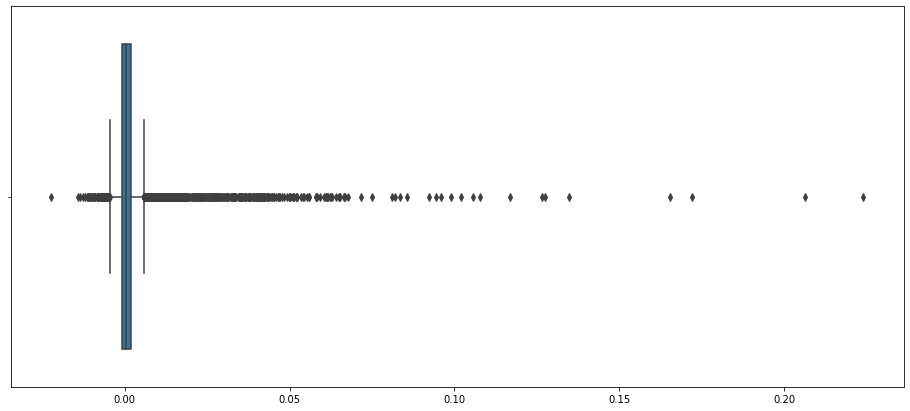

In [90]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=best_scores)

In [47]:
# WRONG HYBRID because scores are not normalized 
rec1 = ItemKNNCFRecommender(URM_all)
rec1.fit(topK=24,
       shrink=19,
       similarity='asymmetric',
       normalize=True,
       asymmetric_alpha=0.21104539434421726,
       feature_weighting='none') #hyperparameters gotten from tuning

rec2 = RP3betaRecommender(URM_all)
rec2.fit(topK=230, alpha=0.5538028817676098, beta=0.3725401274854678, normalize_similarity=True) #hyperparameters gotten from tuning

rec3 = EASE_R_Recommender(URM_all)
rec3.fit(topK=None, normalize_matrix=False, l2_norm=196.614729453597) #hyperparameters gotten from tuning
rec3.W_sparse = sps.csr_matrix(rec3.W_sparse, dtype=np.float32)
rec3.W_sparse.eliminate_zeros()

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 493.46 column/sec. Elapsed time 49.66 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 2110.46 column/sec. Elapsed time 11.61 sec
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 5.86 min


In [49]:
rec_RP3Beta_ItemKNNAsymm = ItemKNNSimilarityHybridRecommender(URM_all, rec1.W_sparse, rec2.W_sparse)
rec_RP3Beta_ItemKNNAsymm.fit(topK=185, alpha=0.10371160354529946)

In [50]:
best_recommender = ItemKNNSimilarityHybridRecommender(URM_all, rec_RP3Beta_ItemKNNAsymm.W_sparse, rec3.W_sparse)
best_recommender.fit(topK=244, alpha=0.5540632500310623)

In [94]:
def prepare_submission(URM_all: pd.DataFrame, users_to_recommend: np.array, recommender: object, at=None):
    users_ids_and_mappings = URM_all[URM_all.user_id.isin(users_to_recommend)][["user_id", "mapped_user_id"]].drop_duplicates()
    items_ids_and_mappings = URM_all[["item_id", "mapped_item_id"]].drop_duplicates()
    
    mapping_to_item_id = dict(zip(URM_all.mapped_item_id, URM_all.item_id))
         
    submission = []

    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id

        ranking = recommender.recommend(user_id_array=mapped_user_id, cutoff=at)

        submission.append((user_id, [mapping_to_item_id[item_id] for item_id in ranking]))
        
    return submission
    

In [95]:
import csv
def write_submission(submissions):
    with open("./Hybrid_ItemKNNRP3EASE_URM_tuned_new_weightsv2.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["user_id", "item_list"])
        for user_id, items in submissions:
            writer.writerow([f"{user_id}", f"{' '.join([str(item) for item in items])}"])

In [96]:
submission = prepare_submission(URM_views_details, users_to_recommend, best_recommender, at=10)

In [97]:
write_submission(submission)